In [1]:
import mne
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import io
import seaborn as sns
import scipy
# Author: Martin Luessi <mluessi@nmr.mgh.harvard.edu>
# License: BSD (3-clause)
from matplotlib.colors import TwoSlopeNorm

import os.path as op
from mne.time_frequency import tfr_multitaper
from mne.stats import permutation_cluster_1samp_test as pcluster_test

from mne_connectivity import spectral_connectivity_epochs, seed_target_indices
from mne.datasets import sample
from mne_connectivity.viz import plot_sensors_connectivity
from mne.stats import permutation_cluster_test
from scipy import stats as stats
from functools import partial

print(__doc__)

Automatically created module for IPython interactive environment


In [2]:
dict015= {'FP1':'eeg','FP2':'eeg','AF7':'eeg','AF3':'eeg','AFz':'eeg','AF4':'eeg','AF8':'eeg','F7':'eeg','F3':'eeg',
          'Fz':'eeg','F4':'eeg','F8':'eeg','FT9':'eeg','FC5':'eeg','FC1':'eeg','FC2':'eeg','FC6':'eeg','FT10':'eeg',
          'T7':'eeg','C3':'eeg','Cz':'eeg','C4':'eeg','T8':'eeg','TP9':'eeg','CP5':'eeg','CP1':'eeg', 'CP2':'eeg',
          'CP6':'eeg','TP10':'eeg','P7':'eeg','P3':'eeg','Pz':'eeg','P4':'eeg','P8':'eeg', 'O1':'eeg','O2':'eeg',
          'DBS1-2':'dbs','DBS2-3':'dbs','DBS3-4':'dbs','DBS4-5':'dbs','DBS5-6':'dbs','DBS6-7':'dbs','DBS7-8':'dbs',
          'mean(DBS1-DBS2, DBS2-DBS3, DBS3-DBS4, DBS4-DBS5, DBS5-DBS6, DBS6-DBS7, DBS7-DBS8)':'dbs',
          'DynL(lc)':'misc','DynR(lc)':'misc','EmgL':'emg','EmgR':'emg','EmgL(lc)':'emg','EmgR(lc)':'emg'}

dict013_imp = {'FP1':'eeg','FP2':'eeg','AF7':'eeg','AF3':'eeg','AFz':'eeg','AF4':'eeg','AF8':'eeg','F7':'eeg','F3':'eeg',
          'Fz':'eeg','F4':'eeg','F8':'eeg','FC5':'eeg','FC1':'eeg','FC2':'eeg','FC6':'eeg',
          'T7':'eeg','C3':'eeg','Cz':'eeg','C4':'eeg','T8':'eeg','FT9':'eeg','CP5':'eeg','CP1':'eeg', 'CP2':'eeg',
          'CP6':'eeg','FT10':'eeg','TP9':'eeg','P3':'eeg','Pz':'eeg','P4':'eeg','P8':'eeg', 'O1':'eeg','O2':'eeg',
          'DBS1-2':'dbs','DBS2-3':'dbs','DBS3-4':'dbs','DBS4-5':'dbs','DBS5-6':'dbs','DBS6-7':'dbs','DBS7-8':'dbs',
          'mean(DBS1-DBS2, DBS2-DBS3, DBS3-DBS4, DBS4-DBS5, DBS5-DBS6, DBS6-DBS7, DBS7-DBS8)':'dbs',
          'DynL(lc)':'misc','DynR(lc)':'misc','EmgL':'emg','EmgR':'emg','EmgL(lc)':'emg','EmgR(lc)':'emg'}

dict013_exp = dict015

dict011_imp = {'FP1':'eeg','FP2':'eeg','AF8':'eeg','AF4':'eeg','AFz':'eeg','AF3':'eeg','AF7':'eeg','F8':'eeg','F4':'eeg','Fz':'eeg','F3':'eeg',
              'F7':'eeg','FC6':'eeg','FC2':'eeg','FC1':'eeg','FC5':'eeg','T8':'eeg','C4':'eeg','Cz':'eeg','C3':'eeg','T7':'eeg','FT10':'eeg',
               'CP6':'eeg','CP2':'eeg','CP1':'eeg', 'CP5':'eeg', 'FT9':'eeg', 'TP10':'eeg','P4':'eeg','Pz':'eeg','P3':'eeg','P7':'eeg','O2':'eeg',
               'O1':'eeg', 'DBS1-2':'dbs','DBS2-3':'dbs','DBS3-4':'dbs','DBS4-5':'dbs','DBS5-6':'dbs','DBS6-7':'dbs','DBS7-8':'dbs',
              'mean(DBS1-DBS2, DBS2-DBS3, DBS3-DBS4, DBS4-DBS5, DBS5-DBS6, DBS6-DBS7, DBS7-DBS8)':'dbs',
             'DynR(lc)':'misc', 'DynL(lc)':'misc','EmgR':'emg','EmgL':'emg','EmgR(lc)':'emg','EmgL(lc)':'emg'}

dict011_exp = {'FP1':'eeg','FP2':'eeg','AF8':'eeg','AF4':'eeg','AFz':'eeg','AF3':'eeg','AF7':'eeg','F8':'eeg','F4':'eeg','Fz':'eeg','F3':'eeg',
              'F7':'eeg','FT10':'eeg', 'FC6':'eeg','FC2':'eeg','FC1':'eeg','FC5':'eeg','FT9':'eeg','T8':'eeg','C4':'eeg','Cz':'eeg','C3':'eeg',
               'T7':'eeg','TP10':'eeg','CP6':'eeg','CP2':'eeg','CP1':'eeg', 'CP5':'eeg', 'TP9':'eeg', 'P8':'eeg','P4':'eeg','Pz':'eeg',
               'P3':'eeg','P7':'eeg','O2':'eeg', 'O1':'eeg', 'DBS1-2':'dbs','DBS2-3':'dbs','DBS3-4':'dbs','DBS4-5':'dbs','DBS5-6':'dbs',
               'DBS6-7':'dbs','DBS7-8':'dbs', 'mean(DBS1-DBS2, DBS2-DBS3, DBS3-DBS4, DBS4-DBS5, DBS5-DBS6, DBS6-DBS7, DBS7-DBS8)':'dbs',
             'DynR(lc)':'misc', 'DynL(lc)':'misc','EmgR':'emg','EmgL':'emg','EmgR(lc)':'emg','EmgL(lc)':'emg'}
           
    
#'DBS1-234':'dbs','DBS234-567':'dbs','DBS567-8':'dbs','mean(DBS1-234, DBS234-567, DBS567-8)':'dbs',

dict08_imp = {'FP1':'eeg','FP2':'eeg','AF8':'eeg','AF4':'eeg','AFz':'eeg','AF3':'eeg','AF7':'eeg','F8':'eeg',
                'F4':'eeg','Fz':'eeg','F3':'eeg','F7':'eeg','FT10':'eeg','FC6':'eeg',
                'FC2':'eeg','FC1':'eeg','FC5':'eeg','FT9':'eeg','T8':'eeg','C4':'eeg','Cz':'eeg','C3':'eeg',
                'T7':'eeg','TP10':'eeg','CP6':'eeg','CP2':'eeg','CP1':'eeg','CP5':'eeg','TP9':'eeg','P4':'eeg',
                'Pz':'eeg','P3':'eeg','O2':'eeg','O1':'eeg',
                'DBS1-2':'dbs', 'DBS1-3':'dbs', 'DBS1-4':'dbs','DBS2-5':'dbs', 'DBS3-6':'dbs', 
                'DBS4-7':'dbs', 'DBS5-8':'dbs', 'DBS6-8':'dbs', 'DBS7-8':'dbs',              
                'mean(DBS1-2, DBS1-3, DBS1-4, DBS2-5, DBS3-6, DBS4-7, DBS5-8, DBS6-8, DBS7-8)':'dbs',             
                'DynR(lc)':'misc',
                'DynL(lc)':'misc','EmgR':'emg','EmgL':'emg','EmgR(lc)':'emg','EmgL(lc)':'emg'}

dict08_exp = {'FP1':'eeg','FP2':'eeg','AF8':'eeg','AF4':'eeg','AFz':'eeg','AF3':'eeg','AF7':'eeg','F8':'eeg',
                'F4':'eeg','Fz':'eeg','F3':'eeg','F7':'eeg','FC6':'eeg', 'FC2':'eeg','FC1':'eeg','FC5':'eeg',
                'T8':'eeg','C4':'eeg','Cz':'eeg','C3':'eeg', 'T7':'eeg','FT10':'eeg', 'CP6':'eeg','CP2':'eeg',
                'CP1':'eeg','CP5':'eeg','FT9':'eeg','TP10':'eeg', 'P4':'eeg','Pz':'eeg','P3':'eeg','P7':'eeg',
                'O2':'eeg','O1':'eeg',
                'DBS1-2':'dbs', 'DBS1-3':'dbs', 'DBS1-4':'dbs','DBS2-5':'dbs', 'DBS3-6':'dbs', 
                'DBS4-7':'dbs', 'DBS5-8':'dbs', 'DBS6-8':'dbs', 'DBS7-8':'dbs',              
                'mean(DBS1-2, DBS1-3, DBS1-4, DBS2-5, DBS3-6, DBS4-7, DBS5-8, DBS6-8, DBS7-8)':'dbs',         
                'DynR(lc)':'misc',
                'DynL(lc)':'misc','EmgR':'emg','EmgL':'emg','EmgR(lc)':'emg','EmgL(lc)':'emg'}

dict07_imp= {'FP1':'eeg','FP2':'eeg','AF8':'eeg','AF4':'eeg','AFz':'eeg','AF3':'eeg','AF7':'eeg','F8':'eeg',
                'F4':'eeg','Fz':'eeg','F3':'eeg','F7':'eeg','FT10':'eeg','FC6':'eeg',
                'FC2':'eeg','FC1':'eeg','FC5':'eeg','FT9':'eeg','T8':'eeg','C4':'eeg','Cz':'eeg','C3':'eeg',
                'T7':'eeg','TP10':'eeg','CP6':'eeg','CP2':'eeg','CP1':'eeg','CP5':'eeg','TP9':'eeg','P4':'eeg',
                'Pz':'eeg','P3':'eeg','O2':'eeg','O1':'eeg',
                'DBS1-2':'dbs', 'DBS1-3':'dbs', 'DBS1-4':'dbs','DBS2-5':'dbs', 'DBS3-6':'dbs',
                'DBS4-7':'dbs', 'DBS5-8':'dbs', 'DBS6-8':'dbs', 'DBS7-8':'dbs',
                'mean(DBS1-2, DBS1-3, DBS1-4, DBS2-5, DBS3-6, DBS4-7, DBS5-8, DBS6-8, DBS7-8)':'dbs',
                'DynR':'misc','DynL':'misc','DynR(lc)':'misc',
                'DynL(lc)':'misc','EmgR':'emg','EmgL':'emg','EmgR(lc)':'emg','EmgL(lc)':'emg'}

dict07_exp= {'FP1':'eeg','FP2':'eeg','AF8':'eeg','AF4':'eeg','AFz':'eeg','AF3':'eeg','AF7':'eeg','F8':'eeg',
                'F4':'eeg','Fz':'eeg','F3':'eeg','F7':'eeg','FT10':'eeg','FC6':'eeg',
                'FC2':'eeg','FC1':'eeg','FC5':'eeg','FT9':'eeg','T8':'eeg','C4':'eeg','Cz':'eeg','C3':'eeg',
                'T7':'eeg','TP10':'eeg','CP6':'eeg','CP2':'eeg','CP1':'eeg','CP5':'eeg','TP9':'eeg','P8':'eeg','P4':'eeg',
                'Pz':'eeg','P3':'eeg','P7':'eeg','O2':'eeg','O1':'eeg',
                'DBS1-2':'dbs', 'DBS1-3':'dbs', 'DBS1-4':'dbs','DBS2-5':'dbs', 'DBS3-6':'dbs',
                'DBS4-7':'dbs', 'DBS5-8':'dbs', 'DBS6-8':'dbs', 'DBS7-8':'dbs',
                'mean(DBS1-2, DBS1-3, DBS1-4, DBS2-5, DBS3-6, DBS4-7, DBS5-8, DBS6-8, DBS7-8)':'dbs',
                'DynR(lc)':'misc',
                'DynL(lc)':'misc','EmgR':'emg','EmgL':'emg','EmgR(lc)':'emg','EmgL(lc)':'emg'}

dict_eog= {'FP1':'eog'}

In [ ]:
base_dir = "E:/Oddball Data/"
subj_list = ['007','008','011','013','014','015']
#subj_list = ['007']

stage = ['implant']#, 'implant']explant
aff_cond = ['1', '101'];
aff_cond_plot = ['Standard_E', 'Standard_NE', 'Oddball_E', 'Oddball_NE'];

naff_cond = ['10', '110'];
hand = 'aff'

tfrs_dbs_all = []
tfrs_all = []
epochs_aff_odd_all = []
epochs_aff_typ_all = []

for sub in subj_list:
    for st in stage:
        data_dir = base_dir+"EDEN"+sub+'/ANALYSIS/'
        fname = data_dir+"data_clean"+st+'.mat'
        
        if hand == 'naff':
            fname = data_dir+"data_clean"+st+'_naff_cond.mat'
            dyno = 'DynR(lc)'
        else:
            fname = data_dir+"data_clean"+st+'.mat'
            dyno = 'DynL(lc)'          

                
        if sub == '015' or sub=='014':
            dict1 = dict015
        elif sub == '013' and st== 'implant':
            dict1 = dict013_imp
        elif sub == '013' and st== 'explant':
            dict1 = dict013_exp
        elif sub == '011' and st== 'implant':
            dict1 = dict011_imp
        elif sub == '011' and st== 'explant':
            dict1 = dict011_exp
        elif sub == '008' and st== 'implant':
            dict1 = dict08_imp
        elif sub == '008' and st== 'explant':
            dict1 = dict08_exp
        elif sub == '007' and st== 'implant':
            dict1 = dict07_imp
        elif sub == '007' and st== 'explant':
            dict1 = dict07_exp

        info = mne.create_info(list(dict1.keys()), sfreq=200, ch_types='misc', verbose=None)
        epochs = mne.read_epochs_fieldtrip(fname,info,data_name='x', trialinfo_column=0)
        
        sfreq = epochs.info['sfreq']
        
        epochs.set_channel_types(dict1)

        kind='easycap-M1'
        mon = mne.channels.make_standard_montage(kind, head_size='auto')
        epochs.set_montage(mon,match_case=False, on_missing='ignore')
        
        #epochs.filter(0.05,30)

        epochs_aff_odd = epochs[aff_cond[1]]
        epochs_aff_typ = epochs[aff_cond[0]]
        
      
        epochs_aff_typ_E = epochs_aff_typ.copy()
        epochs_aff_typ_NE = epochs_aff_typ.copy()
        
        # calculate outlier trial
        tmax = 6
        Dynmo_odd = epochs_aff_odd.copy().crop(-1,tmax).get_data(picks=dyno)
        Dynmo_odd = Dynmo_odd.reshape(Dynmo_odd.shape[0],Dynmo_odd.shape[2])
        
        t_target = int(200+200*1.5)
        #Calculate Error Rate
        ERR_value = []
        for i in range(len(Dynmo_odd)):
            ERR_value1 = ((Dynmo_odd[i,:].max()-Dynmo_odd[i,t_target])*100)/Dynmo_odd[i,t_target]
            ERR_value.append(ERR_value1)
        
        over_thres = 20
        
        outlier_idx=[]
        outlier_idx_odd_no_err=[]
        for j,m in enumerate(ERR_value):
            if (m>over_thres):
                outlier_idx.append(j)
            else:
                outlier_idx_odd_no_err.append(j)
        
        epochs_aff_odd_E=epochs_aff_odd[outlier_idx]
        epochs_aff_odd_NE=epochs_aff_odd[outlier_idx_odd_no_err]
        
        mne.epochs.equalize_epoch_counts([epochs_aff_odd_E,epochs_aff_typ_E], method='truncate')
        mne.epochs.equalize_epoch_counts([epochs_aff_odd_NE,epochs_aff_typ_NE], method='truncate')
        
       
        
        

        '''mne.epochs.equalize_epoch_counts([epochs_aff_odd,epochs_aff_typ], method='truncate')
        
        epochs_aff_odd.set_channel_types(dict_eog)
        epochs_aff_typ.set_channel_types(dict_eog)
 
        epochs_aff_odd_all.append(epochs_aff_odd)
        epochs_aff_typ_all.append(epochs_aff_typ)'''
        
        
        
        
        
        # TFR 
        
        tmin, tmax = -1.5, 4
        freqs = np.arange(1, 30)  # frequencies from 2-100Hz
        
        kwargs = dict(
            n_permutations=100, step_down_p=0.05, seed=1, buffer_size=None, out_type="mask"
        )  # for cluster test
        
        epochs_dbs = [epochs_aff_typ_E.copy().pick(['dbs']), epochs_aff_typ_NE.copy().pick(['dbs']), 
                      epochs_aff_odd_E.copy().pick(['dbs']), epochs_aff_odd_NE.copy().pick(['dbs'])]
        
        epochs = [epochs_aff_typ_E.copy().pick(['eeg']), epochs_aff_typ_NE.copy().pick(['eeg']), 
                  epochs_aff_odd_E.copy().pick(['eeg']), epochs_aff_odd_NE.copy().pick(['eeg'])]
        
        
        #del epochs_aff_typ, epochs_aff_odd
        
        tfrs = []
        for i, epoch in enumerate(epochs):
            
            """tfrs1 = mne.time_frequency.tfr_morlet(epoch, freqs=freqs, n_cycles=5,average=False, return_itc=False)
            """
            """tfrs1 = tfr_multitaper(
                    epoch,
                    freqs=freqs,
                    n_cycles=7,
                    use_fft=True,
                    return_itc=False,
                    average=False,
                    decim=2,
                    n_jobs=50
                )"""

            tfrs1 = epoch.compute_tfr(
                method="morlet",
                freqs=freqs,
                n_cycles=freqs,
                use_fft=True,
                return_itc=False,
                average=False,
                decim=1,
                n_jobs=50
            )

            tfrs1.crop(tmin, tmax)

     
            if i == 0:
                fname = f'{base_dir}TFR_{sub}_{st}_standard_E'                
            elif i==1:
                fname = f'{base_dir}TFR_{sub}_{st}_standard_NE'
            elif i==2:
                fname = f'{base_dir}TFR_{sub}_{st}_oddball_E'
            elif i==3:
                fname = f'{base_dir}TFR_{sub}_{st}_oddball_NE'
            tfrs1.save(fname, overwrite=True, verbose=None)
        
            
        tfrs_dbs = []
        for i, epoch in enumerate(epochs_dbs):

            tfrs1_dbs = epoch.compute_tfr(
                method="morlet",
                freqs=freqs,
                n_cycles=freqs,
                use_fft=True,
                return_itc=False,
                average=False,
                decim=1,
                n_jobs=50
            )


            tfrs1_dbs.crop(tmin, tmax)
        
            if i == 0:
                fname = f'{base_dir}TFR_dbs_{sub}_{st}_standard_E'                
            elif i==1:
                fname = f'{base_dir}TFR_dbs_{sub}_{st}_standard_NE'
            elif i==2:
                fname = f'{base_dir}TFR_dbs_{sub}_{st}_oddball_E'
            elif i==3:
                fname = f'{base_dir}TFR_dbs_{sub}_{st}_oddball_NE'
            tfrs1_dbs.save(fname, overwrite=True, verbose=None)
                        
            
    #tfrs_dbs_all.append(tfrs_dbs)
    #tfrs_all.append(tfrs)

In [3]:
def average_bassline(tfr,comment,event_id):

    tfr_data = tfr.data
    tfr_norm1 =[]
    for ii,ch in enumerate(tfr.ch_names):
        x = np.hstack(tfr_data[:, ii, :, :]) # 3D dim = epoch* freq* time to 2D dim, freq * (time *epoch)
        x_mean=x.mean(axis=1) # mean of all the freqs across all the complete experiment session.
        tfr_norm=[]    
        for j in range(tfr_data[:, ii, :, :].shape[0]):
            tfr_norm.append(((tfr_data[j, ii, :, :].T-x_mean)/x_mean).T) # applying normalaization on each trail

        tfr_norm1.append(tfr_norm)
    tfr_norm1 = np.array(tfr_norm1)
    tfr_norm1 = np.rollaxis(tfr_norm1,1) # normalized tfr data
       
    return mne.time_frequency.EpochsTFR(tfr.info, tfr_norm1, tfr.times, tfr.freqs,comment=comment,events=tfr.events,event_id=event_id) 


In [4]:
base_dir = "E:/Oddball Data/"
subj_list = ['007','008','011','013','014','015']
#subj_list = ['007']

stage = ['implant']#, 'implant']explant
aff_cond = ['1', '101'];
aff_cond_plot = ['Standard_E', 'Standard_NE', 'Oddball_E', 'Oddball_NE']

naff_cond = ['10', '110'];
hand = 'aff'

tfrs_dbs_all = []
tfrs_all = []
epochs_aff_odd_all = []
epochs_aff_typ_all = []


conditions = ['standard_E', 'standard_NE', 'oddball_E', 'oddball_NE']
event_id_E = dict( Standard_E=1,Oddball_E=101)
event_id_NE = dict( Standard_NE=1,Oddball_NE=101)

tfrs_all = []
tfrs_dbs_all =[]
f_max_time = []

crop_min = -1.5
crop_max = 2

for sub in subj_list:
    for st in stage:
        
        
        data_dir = base_dir+"EDEN"+sub+'/ANALYSIS/'
        fname = data_dir+"data_clean"+st+'.mat'
                
        if sub == '015' or sub=='014':
            dict1 = dict015
        elif sub == '013' and st== 'implant':
            dict1 = dict013_imp
        elif sub == '013' and st== 'explant':
            dict1 = dict013_exp
        elif sub == '011' and st== 'implant':
            dict1 = dict011_imp
        elif sub == '011' and st== 'explant':
            dict1 = dict011_exp
        elif sub == '008' and st== 'implant':
            dict1 = dict08_imp
        elif sub == '008' and st== 'explant':
            dict1 = dict08_exp
        elif sub == '007' and st== 'implant':
            dict1 = dict07_imp
        elif sub == '007' and st== 'explant':
            dict1 = dict07_exp

        info = mne.create_info(list(dict1.keys()), sfreq=200, ch_types='misc', verbose=None)
        epochs = mne.read_epochs_fieldtrip(fname,info,data_name='x', trialinfo_column=0)
        epochs_aff_odd = epochs[aff_cond[1]]
        f_max_time.append(np.argmax(epochs_aff_odd.copy().crop(0,1).get_data(picks='DynL(lc)').reshape(epochs_aff_odd.copy().crop(0,1).get_data(picks='DynL(lc)').shape[0],epochs_aff_odd.copy().crop(0,1).get_data(picks='DynL(lc)').shape[2]).mean(axis=0))/200)
       
        tfrs_all1=[]
        tfrs_dbs_all1 = []

        baseline = (-1.4,-0.4)
        mode = 'percent'
        baseline_avg =True
        
        for cond in conditions:
            
            if cond== 'standard_E' or cond== 'oddball_E':
                event_id = event_id_E
            elif cond== 'standard_NE' or cond== 'oddball_NE':
                event_id = event_id_NE
            
            
            if baseline_avg == True:
                fname = f'{base_dir}TFR_{sub}_{st}_{cond}'                
                tfrs_all1.append(average_bassline(mne.time_frequency.read_tfrs(fname).copy().crop(crop_min,crop_max),cond,event_id))
                
                fname_dbs = f'{base_dir}TFR_dbs_{sub}_{st}_{cond}'
                tfrs_dbs_all1.append(average_bassline(mne.time_frequency.read_tfrs(fname_dbs).copy().crop(crop_min,crop_max),cond,event_id))

            else:
                fname = f'{base_dir}TFR_{sub}_{st}_{cond}'                
                tfrs_all1.append(mne.time_frequency.read_tfrs(fname).copy().crop(crop_min,crop_max).apply_baseline(baseline,mode=mode))
                
                fname_dbs = f'{base_dir}TFR_dbs_{sub}_{st}_{cond}'
                tfrs_dbs_all1.append(mne.time_frequency.read_tfrs(fname_dbs).copy().crop(crop_min,crop_max).apply_baseline(baseline,mode=mode))
              
    tfrs_all.append(tfrs_all1)
    tfrs_dbs_all.append(tfrs_dbs_all1)
            

Adding metadata with 9 columns
404 matching events found
No baseline correction applied
Reading E:\Oddball Data\TFR_007_implant_standard_E ...


C:\Users\malann\AppData\Local\Temp\ipykernel_45024\948134136.py:77: RuntimeWarning: This filename (E:\Oddball Data\TFR_007_implant_standard_E) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5, -tfr.hdf5, _tfr.h5 or _tfr.hdf5
  tfrs_all1.append(average_bassline(mne.time_frequency.read_tfrs(fname).copy().crop(crop_min,crop_max),cond,event_id))


Replacing existing metadata with 9 columns
Reading E:\Oddball Data\TFR_dbs_007_implant_standard_E ...


C:\Users\malann\AppData\Local\Temp\ipykernel_45024\424808330.py:16: FutureWarning: Parameters "info", "data", "times", "comment" are deprecated and will be removed in version 1.8. For a quick fix, use ``EpochsTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  return mne.time_frequency.EpochsTFR(tfr.info, tfr_norm1, tfr.times, tfr.freqs,comment=comment,events=tfr.events,event_id=event_id)
C:\Users\malann\AppData\Local\Temp\ipykernel_45024\948134136.py:80: RuntimeWarning: This filename (E:\Oddball Data\TFR_dbs_007_implant_standard_E) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5, -tfr.hdf5, _tfr.h5 or _tfr.hdf5
  tfrs_dbs_all1.append(average_bassline(mne.time_frequency.read_tfrs(fname_dbs).copy().crop(crop_min,crop_max),cond,event_id))


Replacing existing metadata with 9 columns
Reading E:\Oddball Data\TFR_007_implant_standard_NE ...


C:\Users\malann\AppData\Local\Temp\ipykernel_45024\424808330.py:16: FutureWarning: Parameters "info", "data", "times", "comment" are deprecated and will be removed in version 1.8. For a quick fix, use ``EpochsTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  return mne.time_frequency.EpochsTFR(tfr.info, tfr_norm1, tfr.times, tfr.freqs,comment=comment,events=tfr.events,event_id=event_id)
C:\Users\malann\AppData\Local\Temp\ipykernel_45024\948134136.py:77: RuntimeWarning: This filename (E:\Oddball Data\TFR_007_implant_standard_NE) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5, -tfr.hdf5, _tfr.h5 or _tfr.hdf5
  tfrs_all1.append(average_bassline(mne.time_frequency.read_tfrs(fname).copy().crop(crop_min,crop_max),cond,event_id))


Replacing existing metadata with 9 columns
Reading E:\Oddball Data\TFR_dbs_007_implant_standard_NE ...


C:\Users\malann\AppData\Local\Temp\ipykernel_45024\424808330.py:16: FutureWarning: Parameters "info", "data", "times", "comment" are deprecated and will be removed in version 1.8. For a quick fix, use ``EpochsTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  return mne.time_frequency.EpochsTFR(tfr.info, tfr_norm1, tfr.times, tfr.freqs,comment=comment,events=tfr.events,event_id=event_id)
C:\Users\malann\AppData\Local\Temp\ipykernel_45024\948134136.py:80: RuntimeWarning: This filename (E:\Oddball Data\TFR_dbs_007_implant_standard_NE) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5, -tfr.hdf5, _tfr.h5 or _tfr.hdf5
  tfrs_dbs_all1.append(average_bassline(mne.time_frequency.read_tfrs(fname_dbs).copy().crop(crop_min,crop_max),cond,event_id))


Replacing existing metadata with 9 columns
Reading E:\Oddball Data\TFR_007_implant_oddball_E ...


C:\Users\malann\AppData\Local\Temp\ipykernel_45024\424808330.py:16: FutureWarning: Parameters "info", "data", "times", "comment" are deprecated and will be removed in version 1.8. For a quick fix, use ``EpochsTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  return mne.time_frequency.EpochsTFR(tfr.info, tfr_norm1, tfr.times, tfr.freqs,comment=comment,events=tfr.events,event_id=event_id)
C:\Users\malann\AppData\Local\Temp\ipykernel_45024\948134136.py:77: RuntimeWarning: This filename (E:\Oddball Data\TFR_007_implant_oddball_E) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5, -tfr.hdf5, _tfr.h5 or _tfr.hdf5
  tfrs_all1.append(average_bassline(mne.time_frequency.read_tfrs(fname).copy().crop(crop_min,crop_max),cond,event_id))


Replacing existing metadata with 9 columns
Reading E:\Oddball Data\TFR_dbs_007_implant_oddball_E ...


C:\Users\malann\AppData\Local\Temp\ipykernel_45024\424808330.py:16: FutureWarning: Parameters "info", "data", "times", "comment" are deprecated and will be removed in version 1.8. For a quick fix, use ``EpochsTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  return mne.time_frequency.EpochsTFR(tfr.info, tfr_norm1, tfr.times, tfr.freqs,comment=comment,events=tfr.events,event_id=event_id)
C:\Users\malann\AppData\Local\Temp\ipykernel_45024\948134136.py:80: RuntimeWarning: This filename (E:\Oddball Data\TFR_dbs_007_implant_oddball_E) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5, -tfr.hdf5, _tfr.h5 or _tfr.hdf5
  tfrs_dbs_all1.append(average_bassline(mne.time_frequency.read_tfrs(fname_dbs).copy().crop(crop_min,crop_max),cond,event_id))


Replacing existing metadata with 9 columns
Reading E:\Oddball Data\TFR_007_implant_oddball_NE ...


C:\Users\malann\AppData\Local\Temp\ipykernel_45024\424808330.py:16: FutureWarning: Parameters "info", "data", "times", "comment" are deprecated and will be removed in version 1.8. For a quick fix, use ``EpochsTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  return mne.time_frequency.EpochsTFR(tfr.info, tfr_norm1, tfr.times, tfr.freqs,comment=comment,events=tfr.events,event_id=event_id)
C:\Users\malann\AppData\Local\Temp\ipykernel_45024\948134136.py:77: RuntimeWarning: This filename (E:\Oddball Data\TFR_007_implant_oddball_NE) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5, -tfr.hdf5, _tfr.h5 or _tfr.hdf5
  tfrs_all1.append(average_bassline(mne.time_frequency.read_tfrs(fname).copy().crop(crop_min,crop_max),cond,event_id))


Replacing existing metadata with 9 columns
Reading E:\Oddball Data\TFR_dbs_007_implant_oddball_NE ...


C:\Users\malann\AppData\Local\Temp\ipykernel_45024\424808330.py:16: FutureWarning: Parameters "info", "data", "times", "comment" are deprecated and will be removed in version 1.8. For a quick fix, use ``EpochsTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  return mne.time_frequency.EpochsTFR(tfr.info, tfr_norm1, tfr.times, tfr.freqs,comment=comment,events=tfr.events,event_id=event_id)
C:\Users\malann\AppData\Local\Temp\ipykernel_45024\948134136.py:80: RuntimeWarning: This filename (E:\Oddball Data\TFR_dbs_007_implant_oddball_NE) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5, -tfr.hdf5, _tfr.h5 or _tfr.hdf5
  tfrs_dbs_all1.append(average_bassline(mne.time_frequency.read_tfrs(fname_dbs).copy().crop(crop_min,crop_max),cond,event_id))


Replacing existing metadata with 9 columns


C:\Users\malann\AppData\Local\Temp\ipykernel_45024\424808330.py:16: FutureWarning: Parameters "info", "data", "times", "comment" are deprecated and will be removed in version 1.8. For a quick fix, use ``EpochsTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  return mne.time_frequency.EpochsTFR(tfr.info, tfr_norm1, tfr.times, tfr.freqs,comment=comment,events=tfr.events,event_id=event_id)


Adding metadata with 9 columns
431 matching events found
No baseline correction applied
Reading E:\Oddball Data\TFR_008_implant_standard_E ...


C:\Users\malann\AppData\Local\Temp\ipykernel_45024\948134136.py:77: RuntimeWarning: This filename (E:\Oddball Data\TFR_008_implant_standard_E) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5, -tfr.hdf5, _tfr.h5 or _tfr.hdf5
  tfrs_all1.append(average_bassline(mne.time_frequency.read_tfrs(fname).copy().crop(crop_min,crop_max),cond,event_id))


Replacing existing metadata with 9 columns
Reading E:\Oddball Data\TFR_dbs_008_implant_standard_E ...


C:\Users\malann\AppData\Local\Temp\ipykernel_45024\424808330.py:16: FutureWarning: Parameters "info", "data", "times", "comment" are deprecated and will be removed in version 1.8. For a quick fix, use ``EpochsTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  return mne.time_frequency.EpochsTFR(tfr.info, tfr_norm1, tfr.times, tfr.freqs,comment=comment,events=tfr.events,event_id=event_id)
C:\Users\malann\AppData\Local\Temp\ipykernel_45024\948134136.py:80: RuntimeWarning: This filename (E:\Oddball Data\TFR_dbs_008_implant_standard_E) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5, -tfr.hdf5, _tfr.h5 or _tfr.hdf5
  tfrs_dbs_all1.append(average_bassline(mne.time_frequency.read_tfrs(fname_dbs).copy().crop(crop_min,crop_max),cond,event_id))


Replacing existing metadata with 9 columns
Reading E:\Oddball Data\TFR_008_implant_standard_NE ...


C:\Users\malann\AppData\Local\Temp\ipykernel_45024\424808330.py:16: FutureWarning: Parameters "info", "data", "times", "comment" are deprecated and will be removed in version 1.8. For a quick fix, use ``EpochsTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  return mne.time_frequency.EpochsTFR(tfr.info, tfr_norm1, tfr.times, tfr.freqs,comment=comment,events=tfr.events,event_id=event_id)
C:\Users\malann\AppData\Local\Temp\ipykernel_45024\948134136.py:77: RuntimeWarning: This filename (E:\Oddball Data\TFR_008_implant_standard_NE) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5, -tfr.hdf5, _tfr.h5 or _tfr.hdf5
  tfrs_all1.append(average_bassline(mne.time_frequency.read_tfrs(fname).copy().crop(crop_min,crop_max),cond,event_id))


Replacing existing metadata with 9 columns
Reading E:\Oddball Data\TFR_dbs_008_implant_standard_NE ...


C:\Users\malann\AppData\Local\Temp\ipykernel_45024\424808330.py:16: FutureWarning: Parameters "info", "data", "times", "comment" are deprecated and will be removed in version 1.8. For a quick fix, use ``EpochsTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  return mne.time_frequency.EpochsTFR(tfr.info, tfr_norm1, tfr.times, tfr.freqs,comment=comment,events=tfr.events,event_id=event_id)
C:\Users\malann\AppData\Local\Temp\ipykernel_45024\948134136.py:80: RuntimeWarning: This filename (E:\Oddball Data\TFR_dbs_008_implant_standard_NE) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5, -tfr.hdf5, _tfr.h5 or _tfr.hdf5
  tfrs_dbs_all1.append(average_bassline(mne.time_frequency.read_tfrs(fname_dbs).copy().crop(crop_min,crop_max),cond,event_id))


Replacing existing metadata with 9 columns
Reading E:\Oddball Data\TFR_008_implant_oddball_E ...


C:\Users\malann\AppData\Local\Temp\ipykernel_45024\424808330.py:16: FutureWarning: Parameters "info", "data", "times", "comment" are deprecated and will be removed in version 1.8. For a quick fix, use ``EpochsTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  return mne.time_frequency.EpochsTFR(tfr.info, tfr_norm1, tfr.times, tfr.freqs,comment=comment,events=tfr.events,event_id=event_id)
C:\Users\malann\AppData\Local\Temp\ipykernel_45024\948134136.py:77: RuntimeWarning: This filename (E:\Oddball Data\TFR_008_implant_oddball_E) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5, -tfr.hdf5, _tfr.h5 or _tfr.hdf5
  tfrs_all1.append(average_bassline(mne.time_frequency.read_tfrs(fname).copy().crop(crop_min,crop_max),cond,event_id))


Replacing existing metadata with 9 columns
Reading E:\Oddball Data\TFR_dbs_008_implant_oddball_E ...


C:\Users\malann\AppData\Local\Temp\ipykernel_45024\424808330.py:16: FutureWarning: Parameters "info", "data", "times", "comment" are deprecated and will be removed in version 1.8. For a quick fix, use ``EpochsTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  return mne.time_frequency.EpochsTFR(tfr.info, tfr_norm1, tfr.times, tfr.freqs,comment=comment,events=tfr.events,event_id=event_id)
C:\Users\malann\AppData\Local\Temp\ipykernel_45024\948134136.py:80: RuntimeWarning: This filename (E:\Oddball Data\TFR_dbs_008_implant_oddball_E) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5, -tfr.hdf5, _tfr.h5 or _tfr.hdf5
  tfrs_dbs_all1.append(average_bassline(mne.time_frequency.read_tfrs(fname_dbs).copy().crop(crop_min,crop_max),cond,event_id))


Replacing existing metadata with 9 columns
Reading E:\Oddball Data\TFR_008_implant_oddball_NE ...


C:\Users\malann\AppData\Local\Temp\ipykernel_45024\424808330.py:16: FutureWarning: Parameters "info", "data", "times", "comment" are deprecated and will be removed in version 1.8. For a quick fix, use ``EpochsTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  return mne.time_frequency.EpochsTFR(tfr.info, tfr_norm1, tfr.times, tfr.freqs,comment=comment,events=tfr.events,event_id=event_id)
C:\Users\malann\AppData\Local\Temp\ipykernel_45024\948134136.py:77: RuntimeWarning: This filename (E:\Oddball Data\TFR_008_implant_oddball_NE) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5, -tfr.hdf5, _tfr.h5 or _tfr.hdf5
  tfrs_all1.append(average_bassline(mne.time_frequency.read_tfrs(fname).copy().crop(crop_min,crop_max),cond,event_id))


Replacing existing metadata with 9 columns
Reading E:\Oddball Data\TFR_dbs_008_implant_oddball_NE ...


C:\Users\malann\AppData\Local\Temp\ipykernel_45024\424808330.py:16: FutureWarning: Parameters "info", "data", "times", "comment" are deprecated and will be removed in version 1.8. For a quick fix, use ``EpochsTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  return mne.time_frequency.EpochsTFR(tfr.info, tfr_norm1, tfr.times, tfr.freqs,comment=comment,events=tfr.events,event_id=event_id)
C:\Users\malann\AppData\Local\Temp\ipykernel_45024\948134136.py:80: RuntimeWarning: This filename (E:\Oddball Data\TFR_dbs_008_implant_oddball_NE) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5, -tfr.hdf5, _tfr.h5 or _tfr.hdf5
  tfrs_dbs_all1.append(average_bassline(mne.time_frequency.read_tfrs(fname_dbs).copy().crop(crop_min,crop_max),cond,event_id))


Replacing existing metadata with 9 columns


C:\Users\malann\AppData\Local\Temp\ipykernel_45024\424808330.py:16: FutureWarning: Parameters "info", "data", "times", "comment" are deprecated and will be removed in version 1.8. For a quick fix, use ``EpochsTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  return mne.time_frequency.EpochsTFR(tfr.info, tfr_norm1, tfr.times, tfr.freqs,comment=comment,events=tfr.events,event_id=event_id)


Adding metadata with 9 columns
600 matching events found
No baseline correction applied
Reading E:\Oddball Data\TFR_011_implant_standard_E ...


C:\Users\malann\AppData\Local\Temp\ipykernel_45024\948134136.py:77: RuntimeWarning: This filename (E:\Oddball Data\TFR_011_implant_standard_E) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5, -tfr.hdf5, _tfr.h5 or _tfr.hdf5
  tfrs_all1.append(average_bassline(mne.time_frequency.read_tfrs(fname).copy().crop(crop_min,crop_max),cond,event_id))


Replacing existing metadata with 9 columns
Reading E:\Oddball Data\TFR_dbs_011_implant_standard_E ...


C:\Users\malann\AppData\Local\Temp\ipykernel_45024\424808330.py:16: FutureWarning: Parameters "info", "data", "times", "comment" are deprecated and will be removed in version 1.8. For a quick fix, use ``EpochsTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  return mne.time_frequency.EpochsTFR(tfr.info, tfr_norm1, tfr.times, tfr.freqs,comment=comment,events=tfr.events,event_id=event_id)
C:\Users\malann\AppData\Local\Temp\ipykernel_45024\948134136.py:80: RuntimeWarning: This filename (E:\Oddball Data\TFR_dbs_011_implant_standard_E) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5, -tfr.hdf5, _tfr.h5 or _tfr.hdf5
  tfrs_dbs_all1.append(average_bassline(mne.time_frequency.read_tfrs(fname_dbs).copy().crop(crop_min,crop_max),cond,event_id))


Replacing existing metadata with 9 columns
Reading E:\Oddball Data\TFR_011_implant_standard_NE ...


C:\Users\malann\AppData\Local\Temp\ipykernel_45024\424808330.py:16: FutureWarning: Parameters "info", "data", "times", "comment" are deprecated and will be removed in version 1.8. For a quick fix, use ``EpochsTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  return mne.time_frequency.EpochsTFR(tfr.info, tfr_norm1, tfr.times, tfr.freqs,comment=comment,events=tfr.events,event_id=event_id)
C:\Users\malann\AppData\Local\Temp\ipykernel_45024\948134136.py:77: RuntimeWarning: This filename (E:\Oddball Data\TFR_011_implant_standard_NE) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5, -tfr.hdf5, _tfr.h5 or _tfr.hdf5
  tfrs_all1.append(average_bassline(mne.time_frequency.read_tfrs(fname).copy().crop(crop_min,crop_max),cond,event_id))


Replacing existing metadata with 9 columns
Reading E:\Oddball Data\TFR_dbs_011_implant_standard_NE ...


C:\Users\malann\AppData\Local\Temp\ipykernel_45024\424808330.py:16: FutureWarning: Parameters "info", "data", "times", "comment" are deprecated and will be removed in version 1.8. For a quick fix, use ``EpochsTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  return mne.time_frequency.EpochsTFR(tfr.info, tfr_norm1, tfr.times, tfr.freqs,comment=comment,events=tfr.events,event_id=event_id)
C:\Users\malann\AppData\Local\Temp\ipykernel_45024\948134136.py:80: RuntimeWarning: This filename (E:\Oddball Data\TFR_dbs_011_implant_standard_NE) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5, -tfr.hdf5, _tfr.h5 or _tfr.hdf5
  tfrs_dbs_all1.append(average_bassline(mne.time_frequency.read_tfrs(fname_dbs).copy().crop(crop_min,crop_max),cond,event_id))


Replacing existing metadata with 9 columns
Reading E:\Oddball Data\TFR_011_implant_oddball_E ...


C:\Users\malann\AppData\Local\Temp\ipykernel_45024\424808330.py:16: FutureWarning: Parameters "info", "data", "times", "comment" are deprecated and will be removed in version 1.8. For a quick fix, use ``EpochsTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  return mne.time_frequency.EpochsTFR(tfr.info, tfr_norm1, tfr.times, tfr.freqs,comment=comment,events=tfr.events,event_id=event_id)
C:\Users\malann\AppData\Local\Temp\ipykernel_45024\948134136.py:77: RuntimeWarning: This filename (E:\Oddball Data\TFR_011_implant_oddball_E) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5, -tfr.hdf5, _tfr.h5 or _tfr.hdf5
  tfrs_all1.append(average_bassline(mne.time_frequency.read_tfrs(fname).copy().crop(crop_min,crop_max),cond,event_id))


Replacing existing metadata with 9 columns
Reading E:\Oddball Data\TFR_dbs_011_implant_oddball_E ...


C:\Users\malann\AppData\Local\Temp\ipykernel_45024\424808330.py:16: FutureWarning: Parameters "info", "data", "times", "comment" are deprecated and will be removed in version 1.8. For a quick fix, use ``EpochsTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  return mne.time_frequency.EpochsTFR(tfr.info, tfr_norm1, tfr.times, tfr.freqs,comment=comment,events=tfr.events,event_id=event_id)
C:\Users\malann\AppData\Local\Temp\ipykernel_45024\948134136.py:80: RuntimeWarning: This filename (E:\Oddball Data\TFR_dbs_011_implant_oddball_E) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5, -tfr.hdf5, _tfr.h5 or _tfr.hdf5
  tfrs_dbs_all1.append(average_bassline(mne.time_frequency.read_tfrs(fname_dbs).copy().crop(crop_min,crop_max),cond,event_id))


Replacing existing metadata with 9 columns
Reading E:\Oddball Data\TFR_011_implant_oddball_NE ...


C:\Users\malann\AppData\Local\Temp\ipykernel_45024\424808330.py:16: FutureWarning: Parameters "info", "data", "times", "comment" are deprecated and will be removed in version 1.8. For a quick fix, use ``EpochsTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  return mne.time_frequency.EpochsTFR(tfr.info, tfr_norm1, tfr.times, tfr.freqs,comment=comment,events=tfr.events,event_id=event_id)
C:\Users\malann\AppData\Local\Temp\ipykernel_45024\948134136.py:77: RuntimeWarning: This filename (E:\Oddball Data\TFR_011_implant_oddball_NE) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5, -tfr.hdf5, _tfr.h5 or _tfr.hdf5
  tfrs_all1.append(average_bassline(mne.time_frequency.read_tfrs(fname).copy().crop(crop_min,crop_max),cond,event_id))


Replacing existing metadata with 9 columns
Reading E:\Oddball Data\TFR_dbs_011_implant_oddball_NE ...


C:\Users\malann\AppData\Local\Temp\ipykernel_45024\424808330.py:16: FutureWarning: Parameters "info", "data", "times", "comment" are deprecated and will be removed in version 1.8. For a quick fix, use ``EpochsTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  return mne.time_frequency.EpochsTFR(tfr.info, tfr_norm1, tfr.times, tfr.freqs,comment=comment,events=tfr.events,event_id=event_id)
C:\Users\malann\AppData\Local\Temp\ipykernel_45024\948134136.py:80: RuntimeWarning: This filename (E:\Oddball Data\TFR_dbs_011_implant_oddball_NE) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5, -tfr.hdf5, _tfr.h5 or _tfr.hdf5
  tfrs_dbs_all1.append(average_bassline(mne.time_frequency.read_tfrs(fname_dbs).copy().crop(crop_min,crop_max),cond,event_id))


Replacing existing metadata with 9 columns


C:\Users\malann\AppData\Local\Temp\ipykernel_45024\424808330.py:16: FutureWarning: Parameters "info", "data", "times", "comment" are deprecated and will be removed in version 1.8. For a quick fix, use ``EpochsTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  return mne.time_frequency.EpochsTFR(tfr.info, tfr_norm1, tfr.times, tfr.freqs,comment=comment,events=tfr.events,event_id=event_id)


Adding metadata with 9 columns
599 matching events found
No baseline correction applied
Reading E:\Oddball Data\TFR_013_implant_standard_E ...


C:\Users\malann\AppData\Local\Temp\ipykernel_45024\948134136.py:77: RuntimeWarning: This filename (E:\Oddball Data\TFR_013_implant_standard_E) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5, -tfr.hdf5, _tfr.h5 or _tfr.hdf5
  tfrs_all1.append(average_bassline(mne.time_frequency.read_tfrs(fname).copy().crop(crop_min,crop_max),cond,event_id))


Replacing existing metadata with 9 columns
Reading E:\Oddball Data\TFR_dbs_013_implant_standard_E ...


C:\Users\malann\AppData\Local\Temp\ipykernel_45024\424808330.py:16: FutureWarning: Parameters "info", "data", "times", "comment" are deprecated and will be removed in version 1.8. For a quick fix, use ``EpochsTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  return mne.time_frequency.EpochsTFR(tfr.info, tfr_norm1, tfr.times, tfr.freqs,comment=comment,events=tfr.events,event_id=event_id)
C:\Users\malann\AppData\Local\Temp\ipykernel_45024\948134136.py:80: RuntimeWarning: This filename (E:\Oddball Data\TFR_dbs_013_implant_standard_E) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5, -tfr.hdf5, _tfr.h5 or _tfr.hdf5
  tfrs_dbs_all1.append(average_bassline(mne.time_frequency.read_tfrs(fname_dbs).copy().crop(crop_min,crop_max),cond,event_id))


Replacing existing metadata with 9 columns
Reading E:\Oddball Data\TFR_013_implant_standard_NE ...


C:\Users\malann\AppData\Local\Temp\ipykernel_45024\424808330.py:16: FutureWarning: Parameters "info", "data", "times", "comment" are deprecated and will be removed in version 1.8. For a quick fix, use ``EpochsTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  return mne.time_frequency.EpochsTFR(tfr.info, tfr_norm1, tfr.times, tfr.freqs,comment=comment,events=tfr.events,event_id=event_id)
C:\Users\malann\AppData\Local\Temp\ipykernel_45024\948134136.py:77: RuntimeWarning: This filename (E:\Oddball Data\TFR_013_implant_standard_NE) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5, -tfr.hdf5, _tfr.h5 or _tfr.hdf5
  tfrs_all1.append(average_bassline(mne.time_frequency.read_tfrs(fname).copy().crop(crop_min,crop_max),cond,event_id))


Replacing existing metadata with 9 columns
Reading E:\Oddball Data\TFR_dbs_013_implant_standard_NE ...


C:\Users\malann\AppData\Local\Temp\ipykernel_45024\424808330.py:16: FutureWarning: Parameters "info", "data", "times", "comment" are deprecated and will be removed in version 1.8. For a quick fix, use ``EpochsTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  return mne.time_frequency.EpochsTFR(tfr.info, tfr_norm1, tfr.times, tfr.freqs,comment=comment,events=tfr.events,event_id=event_id)
C:\Users\malann\AppData\Local\Temp\ipykernel_45024\948134136.py:80: RuntimeWarning: This filename (E:\Oddball Data\TFR_dbs_013_implant_standard_NE) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5, -tfr.hdf5, _tfr.h5 or _tfr.hdf5
  tfrs_dbs_all1.append(average_bassline(mne.time_frequency.read_tfrs(fname_dbs).copy().crop(crop_min,crop_max),cond,event_id))


Replacing existing metadata with 9 columns
Reading E:\Oddball Data\TFR_013_implant_oddball_E ...


C:\Users\malann\AppData\Local\Temp\ipykernel_45024\424808330.py:16: FutureWarning: Parameters "info", "data", "times", "comment" are deprecated and will be removed in version 1.8. For a quick fix, use ``EpochsTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  return mne.time_frequency.EpochsTFR(tfr.info, tfr_norm1, tfr.times, tfr.freqs,comment=comment,events=tfr.events,event_id=event_id)
C:\Users\malann\AppData\Local\Temp\ipykernel_45024\948134136.py:77: RuntimeWarning: This filename (E:\Oddball Data\TFR_013_implant_oddball_E) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5, -tfr.hdf5, _tfr.h5 or _tfr.hdf5
  tfrs_all1.append(average_bassline(mne.time_frequency.read_tfrs(fname).copy().crop(crop_min,crop_max),cond,event_id))


Replacing existing metadata with 9 columns
Reading E:\Oddball Data\TFR_dbs_013_implant_oddball_E ...


C:\Users\malann\AppData\Local\Temp\ipykernel_45024\424808330.py:16: FutureWarning: Parameters "info", "data", "times", "comment" are deprecated and will be removed in version 1.8. For a quick fix, use ``EpochsTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  return mne.time_frequency.EpochsTFR(tfr.info, tfr_norm1, tfr.times, tfr.freqs,comment=comment,events=tfr.events,event_id=event_id)
C:\Users\malann\AppData\Local\Temp\ipykernel_45024\948134136.py:80: RuntimeWarning: This filename (E:\Oddball Data\TFR_dbs_013_implant_oddball_E) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5, -tfr.hdf5, _tfr.h5 or _tfr.hdf5
  tfrs_dbs_all1.append(average_bassline(mne.time_frequency.read_tfrs(fname_dbs).copy().crop(crop_min,crop_max),cond,event_id))


Replacing existing metadata with 9 columns
Reading E:\Oddball Data\TFR_013_implant_oddball_NE ...


C:\Users\malann\AppData\Local\Temp\ipykernel_45024\424808330.py:16: FutureWarning: Parameters "info", "data", "times", "comment" are deprecated and will be removed in version 1.8. For a quick fix, use ``EpochsTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  return mne.time_frequency.EpochsTFR(tfr.info, tfr_norm1, tfr.times, tfr.freqs,comment=comment,events=tfr.events,event_id=event_id)
C:\Users\malann\AppData\Local\Temp\ipykernel_45024\948134136.py:77: RuntimeWarning: This filename (E:\Oddball Data\TFR_013_implant_oddball_NE) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5, -tfr.hdf5, _tfr.h5 or _tfr.hdf5
  tfrs_all1.append(average_bassline(mne.time_frequency.read_tfrs(fname).copy().crop(crop_min,crop_max),cond,event_id))


Replacing existing metadata with 9 columns
Reading E:\Oddball Data\TFR_dbs_013_implant_oddball_NE ...


C:\Users\malann\AppData\Local\Temp\ipykernel_45024\424808330.py:16: FutureWarning: Parameters "info", "data", "times", "comment" are deprecated and will be removed in version 1.8. For a quick fix, use ``EpochsTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  return mne.time_frequency.EpochsTFR(tfr.info, tfr_norm1, tfr.times, tfr.freqs,comment=comment,events=tfr.events,event_id=event_id)
C:\Users\malann\AppData\Local\Temp\ipykernel_45024\948134136.py:80: RuntimeWarning: This filename (E:\Oddball Data\TFR_dbs_013_implant_oddball_NE) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5, -tfr.hdf5, _tfr.h5 or _tfr.hdf5
  tfrs_dbs_all1.append(average_bassline(mne.time_frequency.read_tfrs(fname_dbs).copy().crop(crop_min,crop_max),cond,event_id))


Replacing existing metadata with 9 columns


C:\Users\malann\AppData\Local\Temp\ipykernel_45024\424808330.py:16: FutureWarning: Parameters "info", "data", "times", "comment" are deprecated and will be removed in version 1.8. For a quick fix, use ``EpochsTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  return mne.time_frequency.EpochsTFR(tfr.info, tfr_norm1, tfr.times, tfr.freqs,comment=comment,events=tfr.events,event_id=event_id)


Adding metadata with 9 columns
494 matching events found
No baseline correction applied
Reading E:\Oddball Data\TFR_014_implant_standard_E ...


C:\Users\malann\AppData\Local\Temp\ipykernel_45024\948134136.py:77: RuntimeWarning: This filename (E:\Oddball Data\TFR_014_implant_standard_E) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5, -tfr.hdf5, _tfr.h5 or _tfr.hdf5
  tfrs_all1.append(average_bassline(mne.time_frequency.read_tfrs(fname).copy().crop(crop_min,crop_max),cond,event_id))


Replacing existing metadata with 9 columns
Reading E:\Oddball Data\TFR_dbs_014_implant_standard_E ...


C:\Users\malann\AppData\Local\Temp\ipykernel_45024\424808330.py:16: FutureWarning: Parameters "info", "data", "times", "comment" are deprecated and will be removed in version 1.8. For a quick fix, use ``EpochsTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  return mne.time_frequency.EpochsTFR(tfr.info, tfr_norm1, tfr.times, tfr.freqs,comment=comment,events=tfr.events,event_id=event_id)
C:\Users\malann\AppData\Local\Temp\ipykernel_45024\948134136.py:80: RuntimeWarning: This filename (E:\Oddball Data\TFR_dbs_014_implant_standard_E) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5, -tfr.hdf5, _tfr.h5 or _tfr.hdf5
  tfrs_dbs_all1.append(average_bassline(mne.time_frequency.read_tfrs(fname_dbs).copy().crop(crop_min,crop_max),cond,event_id))


Replacing existing metadata with 9 columns
Reading E:\Oddball Data\TFR_014_implant_standard_NE ...


C:\Users\malann\AppData\Local\Temp\ipykernel_45024\424808330.py:16: FutureWarning: Parameters "info", "data", "times", "comment" are deprecated and will be removed in version 1.8. For a quick fix, use ``EpochsTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  return mne.time_frequency.EpochsTFR(tfr.info, tfr_norm1, tfr.times, tfr.freqs,comment=comment,events=tfr.events,event_id=event_id)
C:\Users\malann\AppData\Local\Temp\ipykernel_45024\948134136.py:77: RuntimeWarning: This filename (E:\Oddball Data\TFR_014_implant_standard_NE) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5, -tfr.hdf5, _tfr.h5 or _tfr.hdf5
  tfrs_all1.append(average_bassline(mne.time_frequency.read_tfrs(fname).copy().crop(crop_min,crop_max),cond,event_id))


Replacing existing metadata with 9 columns
Reading E:\Oddball Data\TFR_dbs_014_implant_standard_NE ...


C:\Users\malann\AppData\Local\Temp\ipykernel_45024\424808330.py:16: FutureWarning: Parameters "info", "data", "times", "comment" are deprecated and will be removed in version 1.8. For a quick fix, use ``EpochsTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  return mne.time_frequency.EpochsTFR(tfr.info, tfr_norm1, tfr.times, tfr.freqs,comment=comment,events=tfr.events,event_id=event_id)
C:\Users\malann\AppData\Local\Temp\ipykernel_45024\948134136.py:80: RuntimeWarning: This filename (E:\Oddball Data\TFR_dbs_014_implant_standard_NE) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5, -tfr.hdf5, _tfr.h5 or _tfr.hdf5
  tfrs_dbs_all1.append(average_bassline(mne.time_frequency.read_tfrs(fname_dbs).copy().crop(crop_min,crop_max),cond,event_id))


Replacing existing metadata with 9 columns
Reading E:\Oddball Data\TFR_014_implant_oddball_E ...


C:\Users\malann\AppData\Local\Temp\ipykernel_45024\424808330.py:16: FutureWarning: Parameters "info", "data", "times", "comment" are deprecated and will be removed in version 1.8. For a quick fix, use ``EpochsTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  return mne.time_frequency.EpochsTFR(tfr.info, tfr_norm1, tfr.times, tfr.freqs,comment=comment,events=tfr.events,event_id=event_id)
C:\Users\malann\AppData\Local\Temp\ipykernel_45024\948134136.py:77: RuntimeWarning: This filename (E:\Oddball Data\TFR_014_implant_oddball_E) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5, -tfr.hdf5, _tfr.h5 or _tfr.hdf5
  tfrs_all1.append(average_bassline(mne.time_frequency.read_tfrs(fname).copy().crop(crop_min,crop_max),cond,event_id))


Replacing existing metadata with 9 columns
Reading E:\Oddball Data\TFR_dbs_014_implant_oddball_E ...


C:\Users\malann\AppData\Local\Temp\ipykernel_45024\424808330.py:16: FutureWarning: Parameters "info", "data", "times", "comment" are deprecated and will be removed in version 1.8. For a quick fix, use ``EpochsTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  return mne.time_frequency.EpochsTFR(tfr.info, tfr_norm1, tfr.times, tfr.freqs,comment=comment,events=tfr.events,event_id=event_id)
C:\Users\malann\AppData\Local\Temp\ipykernel_45024\948134136.py:80: RuntimeWarning: This filename (E:\Oddball Data\TFR_dbs_014_implant_oddball_E) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5, -tfr.hdf5, _tfr.h5 or _tfr.hdf5
  tfrs_dbs_all1.append(average_bassline(mne.time_frequency.read_tfrs(fname_dbs).copy().crop(crop_min,crop_max),cond,event_id))


Replacing existing metadata with 9 columns
Reading E:\Oddball Data\TFR_014_implant_oddball_NE ...


C:\Users\malann\AppData\Local\Temp\ipykernel_45024\424808330.py:16: FutureWarning: Parameters "info", "data", "times", "comment" are deprecated and will be removed in version 1.8. For a quick fix, use ``EpochsTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  return mne.time_frequency.EpochsTFR(tfr.info, tfr_norm1, tfr.times, tfr.freqs,comment=comment,events=tfr.events,event_id=event_id)
C:\Users\malann\AppData\Local\Temp\ipykernel_45024\948134136.py:77: RuntimeWarning: This filename (E:\Oddball Data\TFR_014_implant_oddball_NE) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5, -tfr.hdf5, _tfr.h5 or _tfr.hdf5
  tfrs_all1.append(average_bassline(mne.time_frequency.read_tfrs(fname).copy().crop(crop_min,crop_max),cond,event_id))


Replacing existing metadata with 9 columns
Reading E:\Oddball Data\TFR_dbs_014_implant_oddball_NE ...


C:\Users\malann\AppData\Local\Temp\ipykernel_45024\424808330.py:16: FutureWarning: Parameters "info", "data", "times", "comment" are deprecated and will be removed in version 1.8. For a quick fix, use ``EpochsTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  return mne.time_frequency.EpochsTFR(tfr.info, tfr_norm1, tfr.times, tfr.freqs,comment=comment,events=tfr.events,event_id=event_id)
C:\Users\malann\AppData\Local\Temp\ipykernel_45024\948134136.py:80: RuntimeWarning: This filename (E:\Oddball Data\TFR_dbs_014_implant_oddball_NE) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5, -tfr.hdf5, _tfr.h5 or _tfr.hdf5
  tfrs_dbs_all1.append(average_bassline(mne.time_frequency.read_tfrs(fname_dbs).copy().crop(crop_min,crop_max),cond,event_id))


Replacing existing metadata with 9 columns


C:\Users\malann\AppData\Local\Temp\ipykernel_45024\424808330.py:16: FutureWarning: Parameters "info", "data", "times", "comment" are deprecated and will be removed in version 1.8. For a quick fix, use ``EpochsTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  return mne.time_frequency.EpochsTFR(tfr.info, tfr_norm1, tfr.times, tfr.freqs,comment=comment,events=tfr.events,event_id=event_id)


Adding metadata with 9 columns
445 matching events found
No baseline correction applied
Reading E:\Oddball Data\TFR_015_implant_standard_E ...


C:\Users\malann\AppData\Local\Temp\ipykernel_45024\948134136.py:77: RuntimeWarning: This filename (E:\Oddball Data\TFR_015_implant_standard_E) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5, -tfr.hdf5, _tfr.h5 or _tfr.hdf5
  tfrs_all1.append(average_bassline(mne.time_frequency.read_tfrs(fname).copy().crop(crop_min,crop_max),cond,event_id))


Replacing existing metadata with 9 columns
Reading E:\Oddball Data\TFR_dbs_015_implant_standard_E ...


C:\Users\malann\AppData\Local\Temp\ipykernel_45024\424808330.py:16: FutureWarning: Parameters "info", "data", "times", "comment" are deprecated and will be removed in version 1.8. For a quick fix, use ``EpochsTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  return mne.time_frequency.EpochsTFR(tfr.info, tfr_norm1, tfr.times, tfr.freqs,comment=comment,events=tfr.events,event_id=event_id)
C:\Users\malann\AppData\Local\Temp\ipykernel_45024\948134136.py:80: RuntimeWarning: This filename (E:\Oddball Data\TFR_dbs_015_implant_standard_E) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5, -tfr.hdf5, _tfr.h5 or _tfr.hdf5
  tfrs_dbs_all1.append(average_bassline(mne.time_frequency.read_tfrs(fname_dbs).copy().crop(crop_min,crop_max),cond,event_id))


Replacing existing metadata with 9 columns
Reading E:\Oddball Data\TFR_015_implant_standard_NE ...


C:\Users\malann\AppData\Local\Temp\ipykernel_45024\424808330.py:16: FutureWarning: Parameters "info", "data", "times", "comment" are deprecated and will be removed in version 1.8. For a quick fix, use ``EpochsTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  return mne.time_frequency.EpochsTFR(tfr.info, tfr_norm1, tfr.times, tfr.freqs,comment=comment,events=tfr.events,event_id=event_id)
C:\Users\malann\AppData\Local\Temp\ipykernel_45024\948134136.py:77: RuntimeWarning: This filename (E:\Oddball Data\TFR_015_implant_standard_NE) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5, -tfr.hdf5, _tfr.h5 or _tfr.hdf5
  tfrs_all1.append(average_bassline(mne.time_frequency.read_tfrs(fname).copy().crop(crop_min,crop_max),cond,event_id))


Replacing existing metadata with 9 columns
Reading E:\Oddball Data\TFR_dbs_015_implant_standard_NE ...


C:\Users\malann\AppData\Local\Temp\ipykernel_45024\424808330.py:16: FutureWarning: Parameters "info", "data", "times", "comment" are deprecated and will be removed in version 1.8. For a quick fix, use ``EpochsTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  return mne.time_frequency.EpochsTFR(tfr.info, tfr_norm1, tfr.times, tfr.freqs,comment=comment,events=tfr.events,event_id=event_id)
C:\Users\malann\AppData\Local\Temp\ipykernel_45024\948134136.py:80: RuntimeWarning: This filename (E:\Oddball Data\TFR_dbs_015_implant_standard_NE) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5, -tfr.hdf5, _tfr.h5 or _tfr.hdf5
  tfrs_dbs_all1.append(average_bassline(mne.time_frequency.read_tfrs(fname_dbs).copy().crop(crop_min,crop_max),cond,event_id))


Replacing existing metadata with 9 columns
Reading E:\Oddball Data\TFR_015_implant_oddball_E ...


C:\Users\malann\AppData\Local\Temp\ipykernel_45024\424808330.py:16: FutureWarning: Parameters "info", "data", "times", "comment" are deprecated and will be removed in version 1.8. For a quick fix, use ``EpochsTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  return mne.time_frequency.EpochsTFR(tfr.info, tfr_norm1, tfr.times, tfr.freqs,comment=comment,events=tfr.events,event_id=event_id)
C:\Users\malann\AppData\Local\Temp\ipykernel_45024\948134136.py:77: RuntimeWarning: This filename (E:\Oddball Data\TFR_015_implant_oddball_E) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5, -tfr.hdf5, _tfr.h5 or _tfr.hdf5
  tfrs_all1.append(average_bassline(mne.time_frequency.read_tfrs(fname).copy().crop(crop_min,crop_max),cond,event_id))


Replacing existing metadata with 9 columns
Reading E:\Oddball Data\TFR_dbs_015_implant_oddball_E ...


C:\Users\malann\AppData\Local\Temp\ipykernel_45024\424808330.py:16: FutureWarning: Parameters "info", "data", "times", "comment" are deprecated and will be removed in version 1.8. For a quick fix, use ``EpochsTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  return mne.time_frequency.EpochsTFR(tfr.info, tfr_norm1, tfr.times, tfr.freqs,comment=comment,events=tfr.events,event_id=event_id)
C:\Users\malann\AppData\Local\Temp\ipykernel_45024\948134136.py:80: RuntimeWarning: This filename (E:\Oddball Data\TFR_dbs_015_implant_oddball_E) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5, -tfr.hdf5, _tfr.h5 or _tfr.hdf5
  tfrs_dbs_all1.append(average_bassline(mne.time_frequency.read_tfrs(fname_dbs).copy().crop(crop_min,crop_max),cond,event_id))


Replacing existing metadata with 9 columns
Reading E:\Oddball Data\TFR_015_implant_oddball_NE ...


C:\Users\malann\AppData\Local\Temp\ipykernel_45024\424808330.py:16: FutureWarning: Parameters "info", "data", "times", "comment" are deprecated and will be removed in version 1.8. For a quick fix, use ``EpochsTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  return mne.time_frequency.EpochsTFR(tfr.info, tfr_norm1, tfr.times, tfr.freqs,comment=comment,events=tfr.events,event_id=event_id)
C:\Users\malann\AppData\Local\Temp\ipykernel_45024\948134136.py:77: RuntimeWarning: This filename (E:\Oddball Data\TFR_015_implant_oddball_NE) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5, -tfr.hdf5, _tfr.h5 or _tfr.hdf5
  tfrs_all1.append(average_bassline(mne.time_frequency.read_tfrs(fname).copy().crop(crop_min,crop_max),cond,event_id))


Replacing existing metadata with 9 columns
Reading E:\Oddball Data\TFR_dbs_015_implant_oddball_NE ...


C:\Users\malann\AppData\Local\Temp\ipykernel_45024\424808330.py:16: FutureWarning: Parameters "info", "data", "times", "comment" are deprecated and will be removed in version 1.8. For a quick fix, use ``EpochsTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  return mne.time_frequency.EpochsTFR(tfr.info, tfr_norm1, tfr.times, tfr.freqs,comment=comment,events=tfr.events,event_id=event_id)
C:\Users\malann\AppData\Local\Temp\ipykernel_45024\948134136.py:80: RuntimeWarning: This filename (E:\Oddball Data\TFR_dbs_015_implant_oddball_NE) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5, -tfr.hdf5, _tfr.h5 or _tfr.hdf5
  tfrs_dbs_all1.append(average_bassline(mne.time_frequency.read_tfrs(fname_dbs).copy().crop(crop_min,crop_max),cond,event_id))


Replacing existing metadata with 9 columns


C:\Users\malann\AppData\Local\Temp\ipykernel_45024\424808330.py:16: FutureWarning: Parameters "info", "data", "times", "comment" are deprecated and will be removed in version 1.8. For a quick fix, use ``EpochsTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  return mne.time_frequency.EpochsTFR(tfr.info, tfr_norm1, tfr.times, tfr.freqs,comment=comment,events=tfr.events,event_id=event_id)


In [5]:
tfrs_all

[[<TFR from Epochs, unknown method | 44 epochs × 34 channels × 29 freqs × 701 times, 1.0 - 29.0 Hz, -1.50 - 2.00 s, 232.1 MB>,
  <TFR from Epochs, unknown method | 4 epochs × 34 channels × 29 freqs × 701 times, 1.0 - 29.0 Hz, -1.50 - 2.00 s, 21.2 MB>,
  <TFR from Epochs, unknown method | 44 epochs × 34 channels × 29 freqs × 701 times, 1.0 - 29.0 Hz, -1.50 - 2.00 s, 232.1 MB>,
  <TFR from Epochs, unknown method | 4 epochs × 34 channels × 29 freqs × 701 times, 1.0 - 29.0 Hz, -1.50 - 2.00 s, 21.2 MB>],
 [<TFR from Epochs, unknown method | 48 epochs × 34 channels × 29 freqs × 701 times, 1.0 - 29.0 Hz, -1.50 - 2.00 s, 253.2 MB>,
  <TFR from Epochs, unknown method | 2 epochs × 34 channels × 29 freqs × 701 times, 1.0 - 29.0 Hz, -1.50 - 2.00 s, 10.6 MB>,
  <TFR from Epochs, unknown method | 48 epochs × 34 channels × 29 freqs × 701 times, 1.0 - 29.0 Hz, -1.50 - 2.00 s, 253.2 MB>,
  <TFR from Epochs, unknown method | 2 epochs × 34 channels × 29 freqs × 701 times, 1.0 - 29.0 Hz, -1.50 - 2.00 s, 1

# Plot EEG ERDS

1
2
3
No baseline correction applied
No baseline correction applied


C:\Users\malann\AppData\Local\Temp\ipykernel_45024\3402396182.py:94: RuntimeWarning: `mask` is None, not masking the plot ...
  tfr_typ_avg_resp1.copy().crop(crop_min,cropm_max).plot(
C:\Users\malann\AppData\Local\Temp\ipykernel_45024\3402396182.py:102: RuntimeWarning: `mask` is None, not masking the plot ...
  tfr_odd_avg_resp1.copy().crop(crop_min,cropm_max).plot(


No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No basel

C:\Users\malann\AppData\Local\Temp\ipykernel_45024\3402396182.py:94: RuntimeWarning: `mask` is None, not masking the plot ...
  tfr_typ_avg_resp1.copy().crop(crop_min,cropm_max).plot(
C:\Users\malann\AppData\Local\Temp\ipykernel_45024\3402396182.py:102: RuntimeWarning: `mask` is None, not masking the plot ...
  tfr_odd_avg_resp1.copy().crop(crop_min,cropm_max).plot(


No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
No basel

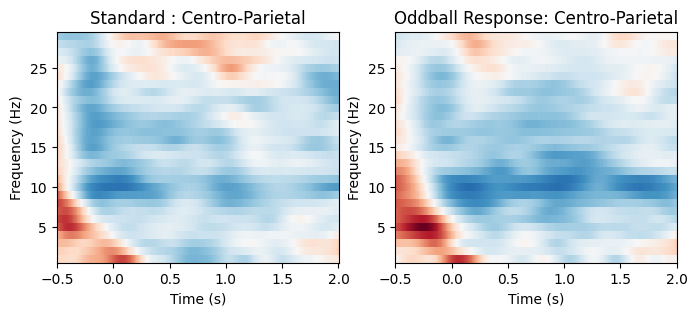

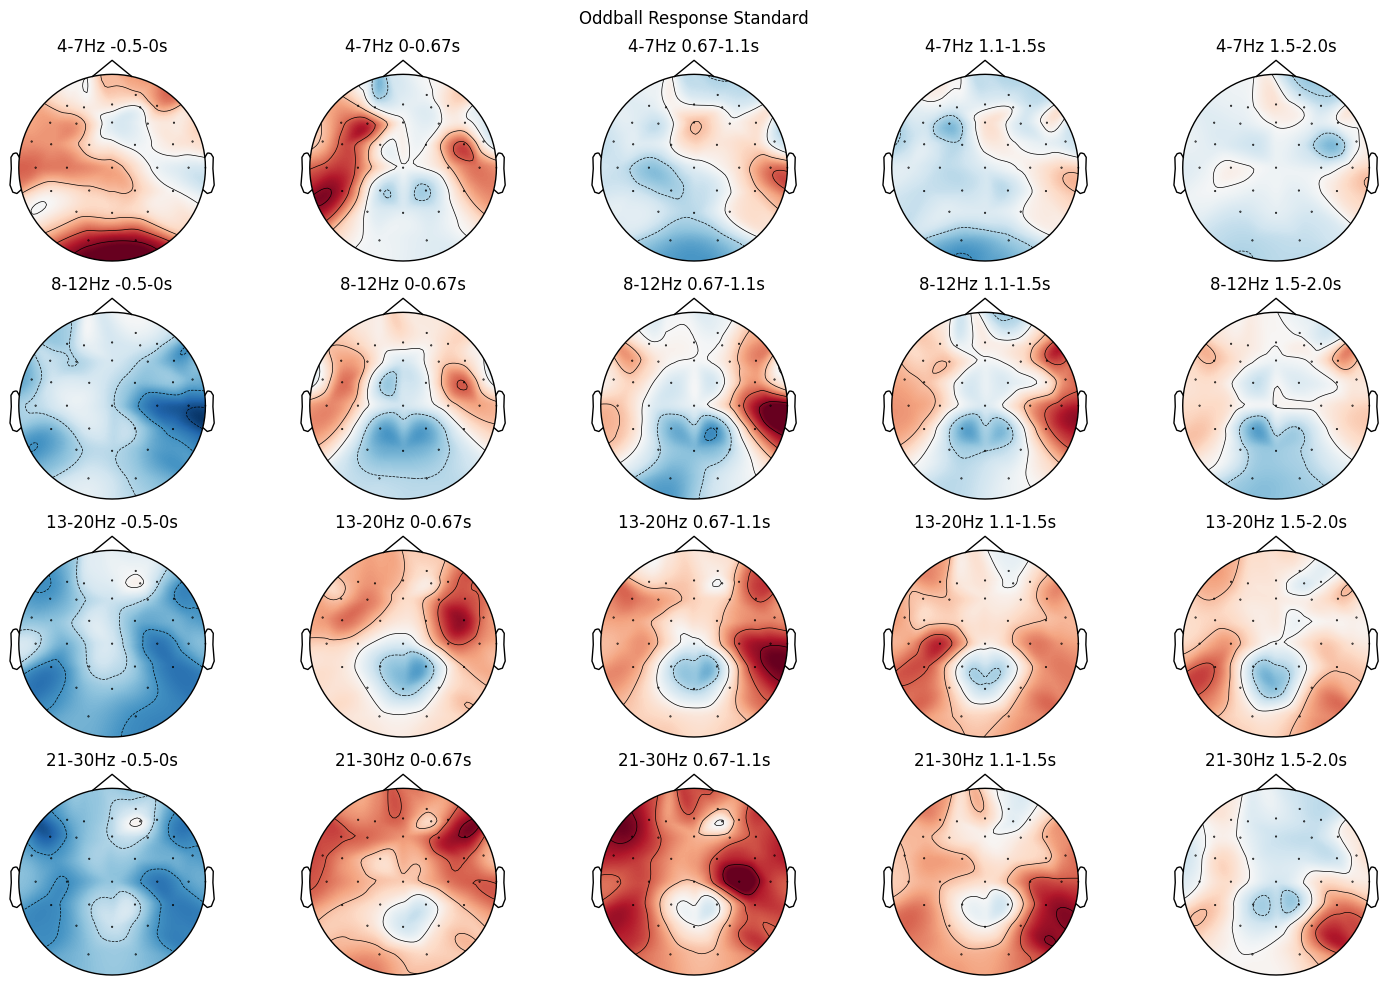

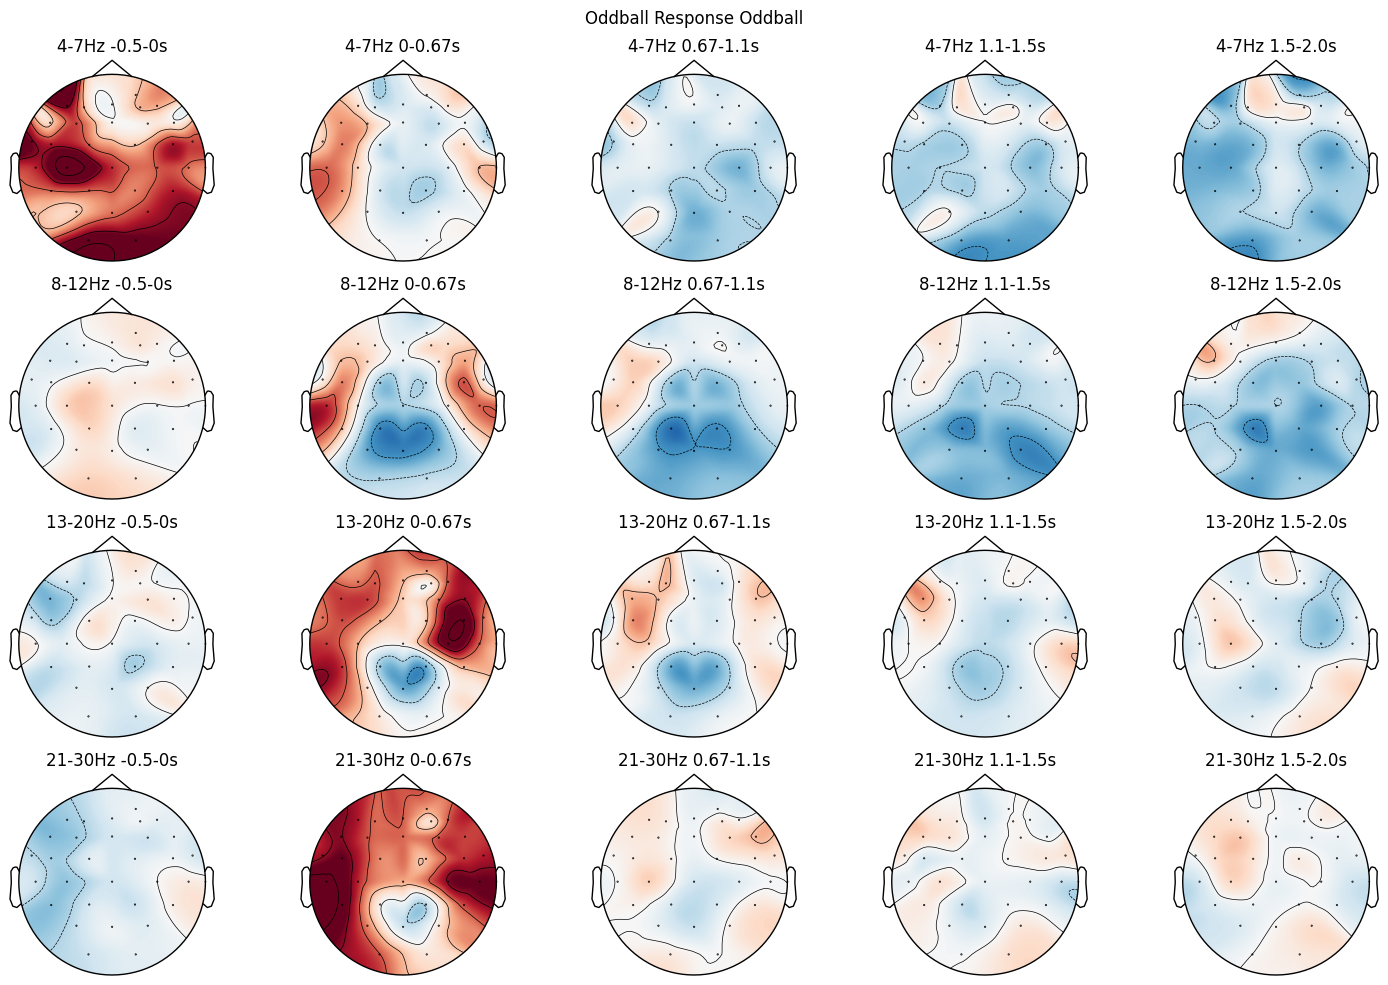

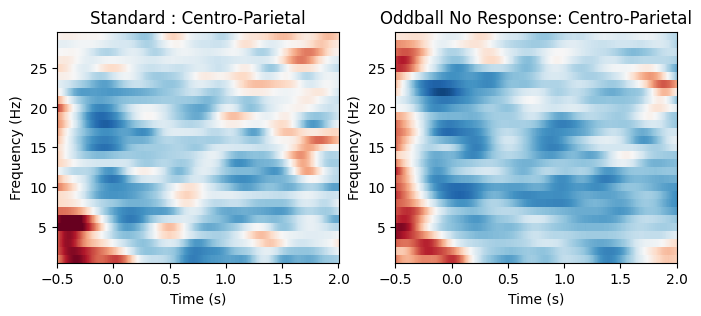

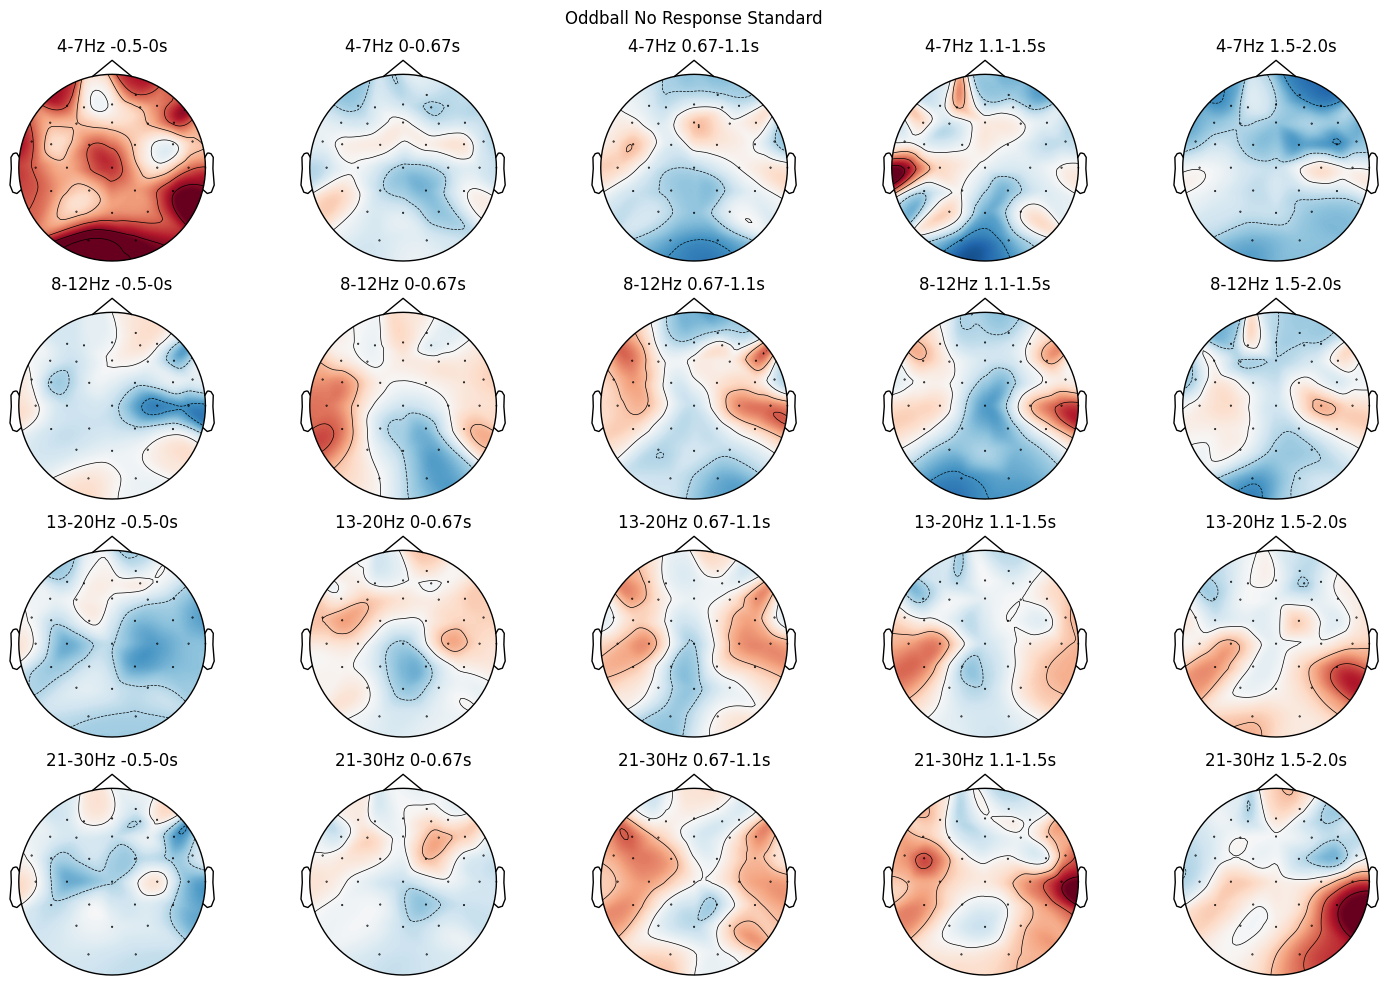

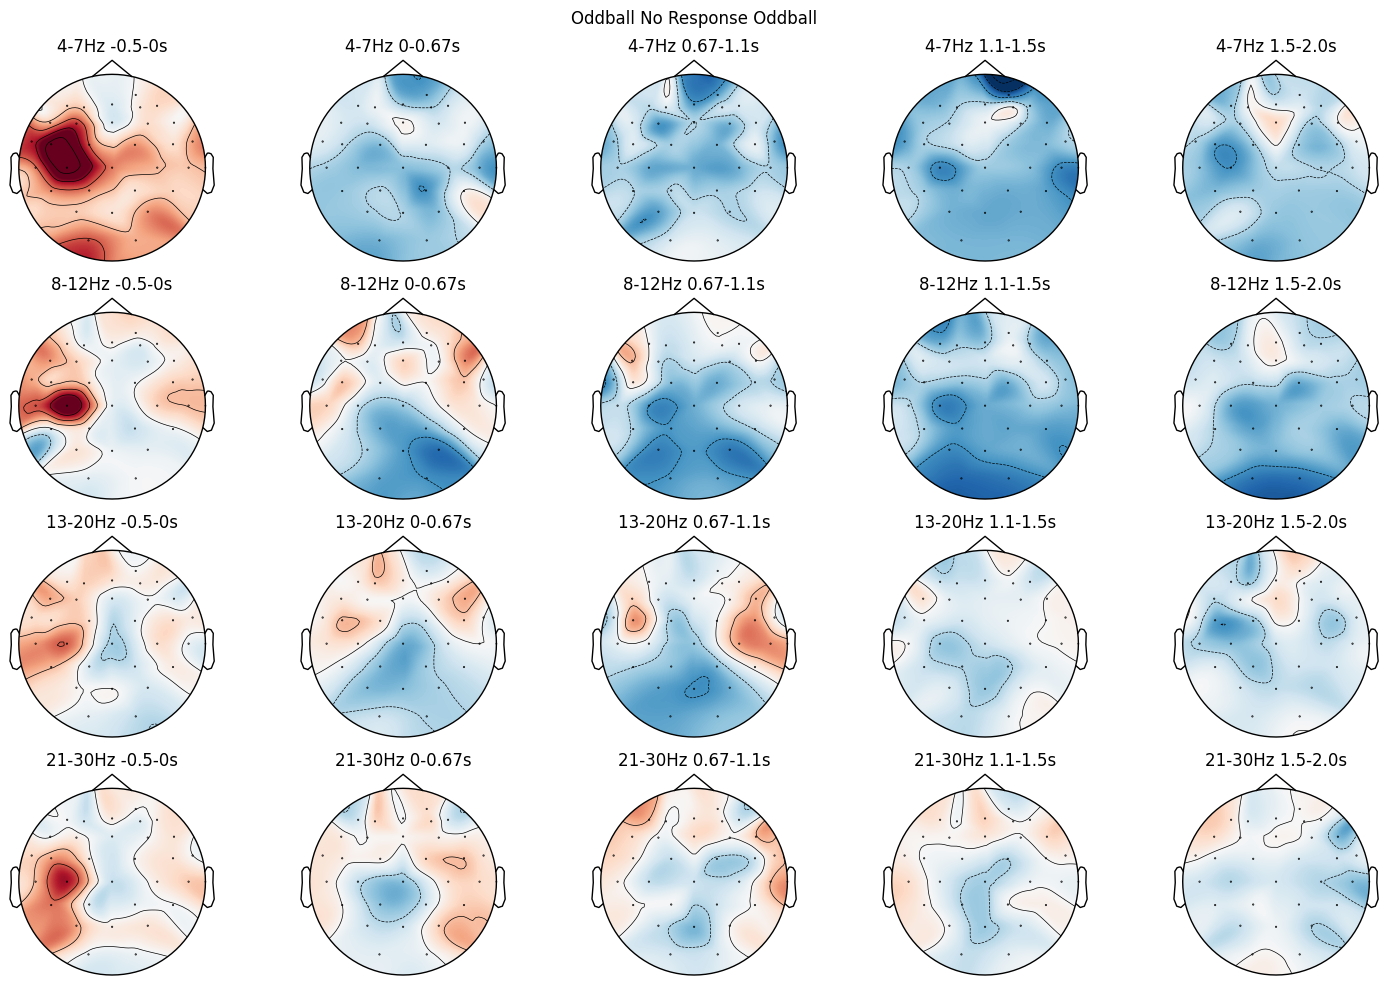

In [7]:
resp = {'007':0,'008':1,'011':2,'013':3}
non_resp = {'008':1,'011':2,'013':3,'014':4,'015':5}
event_id = dict( Standard=1,Oddball=101)
ch_picks = ['FP2', 'AF8',  'AF4', 'AFz', 'AF3', 'AF7', 'F8', 'F4', 'Fz', 'F3', 'F7', 'FT10', 'FC6', 'FC2', 'FC1', 'FC5', 'FT9',
            'T8', 'C4', 'Cz', 'C3', 'T7', 'CP6', 'CP2', 'CP1', 'CP5', 'P4', 'Pz', 'P3', 'O2', 'O1']

task_res = ['Oddball Response', 'Oddball No Response']
tfr_typ_data_E = []
tfr_typ_data_NE = []
tfr_odd_data_E = []
tfr_odd_data_NE = []

for ires, res in enumerate(task_res):
    if res == 'Oddball Response':
        resp_idx = list(resp.values())
        
        tfr_typ_avg = []
        tfr_odd_avg = []
        for i in resp_idx:
            tfr_typ_data_E.append(tfrs_all[i][0].copy().pick(ch_picks).get_data())
            tfr_avg = tfrs_all[i][0].copy().pick(ch_picks).get_data().mean(axis = 0)
            tfrs_typ_avg = mne.time_frequency.AverageTFRArray(tfrs_all[i][0].copy().pick(ch_picks).info, tfr_avg, tfrs_all[i][0].times, tfrs_all[i][0].freqs,comment=aff_cond_plot[0])
            tfr_typ_avg.append(tfrs_typ_avg)
            
            tfr_odd_data_E.append(tfrs_all[i][2].copy().pick(ch_picks).get_data())
            odd_avg = tfrs_all[i][2].copy().pick(ch_picks).get_data().mean(axis = 0)
            tfrs_odd_avg = mne.time_frequency.AverageTFRArray(tfrs_all[i][1].copy().pick(ch_picks).info, odd_avg, tfrs_all[i][1].times, tfrs_all[i][1].freqs,comment=aff_cond_plot[1])
            tfr_odd_avg.append(tfrs_odd_avg)

    elif res == 'Oddball No Response':
        resp_idx = list(non_resp.values())
        tfr_typ_avg = []
        tfr_odd_avg = []
        for i in resp_idx:
            tfr_typ_data_NE.append(tfrs_all[i][1].copy().pick(ch_picks).get_data())
            tfr_avg = tfrs_all[i][1].copy().pick(ch_picks).get_data().mean(axis = 0)
            tfrs_typ_avg = mne.time_frequency.AverageTFRArray(tfrs_all[i][0].copy().pick(ch_picks).info, tfr_avg, tfrs_all[i][0].times, tfrs_all[i][0].freqs,comment=aff_cond_plot[0])
            tfr_typ_avg.append(tfrs_typ_avg)
            
            tfr_odd_data_NE.append(tfrs_all[i][3].copy().pick(ch_picks).get_data())
            odd_avg = tfrs_all[i][3].copy().pick(ch_picks).get_data().mean(axis = 0)
            tfrs_odd_avg = mne.time_frequency.AverageTFRArray(tfrs_all[i][1].copy().pick(ch_picks).info, odd_avg, tfrs_all[i][1].times, tfrs_all[i][1].freqs,comment=aff_cond_plot[1])
            tfr_odd_avg.append(tfrs_odd_avg)    


    if baseline_avg ==True:
        vmin, vmax = -0.5, 0.5  # set min and max ERDS values in plot
    else:
        vmin, vmax = -100, 100  # set min and max ERDS values in plot
    cnorm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)  # min, center & max ERDS
    
    tfr_typ_avg_resp = tfr_typ_avg[0]
    for i in range(1, len(tfr_typ_avg)):
        print(i)
        tfr_typ_avg_resp += tfr_typ_avg[i]
    tfr_typ_avg_resp = tfr_typ_avg_resp/(i+1)
        
    tfr_odd_avg_resp = tfr_odd_avg[0]
    for i in range(1, len(tfr_odd_avg)):
        tfr_odd_avg_resp += tfr_odd_avg[i]
    tfr_odd_avg_resp = tfr_odd_avg_resp/(i+1)
    
    tfr_diff_avg_resp=tfr_odd_avg_resp-tfr_typ_avg_resp

    
# Channel to plot from average
    ch_plot = 'CP2'
    ch_plot_name = ch_plot
    fig, axes = plt.subplots(1,2, figsize = (8,3))

    avg = True
    region = 'CP'
    
    if avg==True:
        if region == 'FC':
            ch_picks_ipsi =['FC2','FC1','Cz','Fz']
            ch_plot_name = 'Fronto-Central'
        elif region == 'CP':
            ch_picks_ipsi =['CP2','CP1','Cz','Pz']
            ch_plot_name = 'Centro-Parietal'
        elif region == 'ipsi':
            ch_picks_ipsi =['FC6','C4','FC2']
            ch_plot_name = 'Ipsilesional'
            
        tfr_typ_avg_resp1 = tfr_typ_avg_resp.copy().pick(ch_picks_ipsi).get_data().mean(axis=0)
        tfr_typ_avg_resp1 = tfr_typ_avg_resp1.reshape(1,tfr_typ_avg_resp1.shape[0],tfr_typ_avg_resp1.shape[1])
        tfr_typ_avg_resp1 = mne.time_frequency.AverageTFRArray(tfrs_all[i][1].copy().pick(ch_picks[0]).info, tfr_typ_avg_resp1, tfrs_all[i][1].times, tfrs_all[i][1].freqs,comment=aff_cond_plot[1])
        
        tfr_odd_avg_resp1 = tfr_odd_avg_resp.copy().pick(ch_picks_ipsi).get_data().mean(axis=0)
        tfr_odd_avg_resp1 = tfr_odd_avg_resp1.reshape(1,tfr_odd_avg_resp1.shape[0],tfr_odd_avg_resp1.shape[1])
        tfr_odd_avg_resp1 = mne.time_frequency.AverageTFRArray(tfrs_all[i][1].copy().pick(ch_picks[0]).info, tfr_odd_avg_resp1, tfrs_all[i][1].times, tfrs_all[i][1].freqs,comment=aff_cond_plot[1])

        crop_min,cropm_max = -0.5,2.0
        tfr_typ_avg_resp1.copy().crop(crop_min,cropm_max).plot(
                            ch_picks[0],
                            colorbar=False,
                            cnorm=cnorm,
                            axes = axes[0],
                            mask_style="mask",
                            show=False,
                        )
        tfr_odd_avg_resp1.copy().crop(crop_min,cropm_max).plot(
                            ch_picks[0],
                            colorbar=False,
                            cnorm=cnorm,
                            axes = axes[1],
                            mask_style="mask",
                            show=False                )

        tfr_diff_avg_resp1=tfr_odd_avg_resp1.copy().crop(crop_min,cropm_max)-tfr_typ_avg_resp1.copy().crop(crop_min,cropm_max)


        axes[0].set_title(f'Standard : {ch_plot_name}')
        axes[1].set_title(f'{res}: {ch_plot_name}')

    
    else:


        tfr_typ_avg_resp.copy().crop(crop_min,cropm_max).plot(
                            ch_plot,
                            colorbar=False,
                            cnorm=cnorm,
                            axes = axes[0],
                            mask_style="mask",
                            show=False,
                        )
        
        tfr_odd_avg_resp.copy().crop(crop_min,cropm_max).plot(
                            ch_plot,
                            colorbar=False,
                            cnorm=cnorm,
                            axes = axes[1],
                            mask_style="mask",
                            show=False                )

    
        axes[0].set_title(f'Standard : {ch_plot_name}')
        axes[1].set_title(f'{res}: {ch_plot_name}')
    
    
    fmins = [4,8,13,21]
    fmaxs = [7,12,20,30]
        
    f_max_time_avg = round((sum(f_max_time)/len(f_max_time)),2)
    tmins = [-0.5, 0, f_max_time_avg , 1.1, 1.5]
    tmaxs = [0, f_max_time_avg, 1.1, 1.5, 2.0]
    fig1, axes1_row = plt.subplots(len(fmins),len(tmins),figsize=(15,10))
    fig2, axes2_row = plt.subplots(len(fmins),len(tmins),figsize=(15,10))
    
    for axes1, fmin,fmax in zip(axes1_row, fmins,fmaxs):
        for tmin,tmax,ax1 in zip(tmins,tmaxs,axes1):
            tfr_typ_avg_resp.plot_topomap(tmin=tmin, tmax=tmax,fmin=fmin, fmax=fmax,axes=ax1,show=False,vlim=(vmin,vmax),colorbar=False)
            ax1.set_title(f'{fmin}-{fmax}Hz {tmin}-{tmax}s')
    fig1.suptitle(f'{res} Standard')
    fig1.tight_layout()
    for axes2, fmin,fmax in zip(axes2_row, fmins,fmaxs):
        for tmin,tmax,ax2 in zip(tmins,tmaxs,axes2):
            tfr_odd_avg_resp.plot_topomap(tmin=tmin, tmax=tmax,fmin=fmin, fmax=fmax,axes=ax2,show=False,vlim=(vmin,vmax),colorbar=False)
            ax2.set_title(f'{fmin}-{fmax}Hz {tmin}-{tmax}s')
    fig2.suptitle(f'{res} Oddball')
    fig2.tight_layout()




# EEG ERDS correlation with Clinical scores

In [8]:
# correlation with UEFMS and AMT
UEFMS_implant = {'007':5,'008':10,'011':12,'013':7,'014':7,'015':9}
UEFMS_explant = {'007':6,'008':16,'011':20,'013':17,'014':20,'015':19}
UEFMS_change = {'007':20,'008':60,'011':67,'013':143,'014':186,'015':111}

AMT_implant = {'007':1.64,'008':3.75,'011':2.82,'013':2.92,'014':2.71,'015':3.14}
AMT_explant = {'007':2.53,'008':4.46,'011':4.32,'013':4.64,'014':4.35,'015':4.60}
AMT_change = {'007':54.3,'008':19.0,'011':53.2,'013':58.5,'014':60.5,'015':46.6}


UEFMS_delta = {'007':1,'008':6,'011':8,'013':10,'014':13,'015':10}

AMT_delta = {'007':25,'008':20,'011':42,'013':48,'014':46,'015':41}


In [10]:
fmins = [4,8,13,21]
fmaxs = [7,12,20,30]

f_max_time_avg = round((sum(f_max_time)/len(f_max_time)),2)
tmins = [-0.5, 0, f_max_time_avg , 1.1, 1.5]
tmaxs = [0, f_max_time_avg, 1.1, 1.5, 2.0]
corr_mat = []

region = 'CP'

if avg==True:
    if region == 'FC':
        ch_picks_ipsi =['FC2','FC1','Cz','Fz']
        ch_plot_name = 'Fronto-Central'
    elif region == 'CP':
        ch_picks_ipsi =['CP2','CP1','Cz','Pz']
        ch_plot_name = 'Centro-Parietal'
    elif region == 'ipsi':
        ch_picks_ipsi =['FC6','C4','FC2']
        ch_plot_name = 'Ipsilesional'

for ires, res in enumerate(task_res):
    if res == 'Oddball Response':
        resp_idx = list(resp.values())
        
        tfr_typ_avg = []
        tfr_odd_avg = []
        for i in resp_idx:
            tfr_typ_data_E.append(tfrs_all[i][0].copy().pick(ch_picks).get_data())
            tfr_avg = tfrs_all[i][0].copy().pick(ch_picks).get_data().mean(axis = 0)
            tfrs_typ_avg = mne.time_frequency.AverageTFRArray(tfrs_all[i][0].copy().pick(ch_picks).info, tfr_avg, tfrs_all[i][0].times, tfrs_all[i][0].freqs,comment=aff_cond_plot[0])
            tfr_typ_avg.append(tfrs_typ_avg)
            
            tfr_odd_data_E.append(tfrs_all[i][2].copy().pick(ch_picks).get_data())
            odd_avg = tfrs_all[i][2].copy().pick(ch_picks).get_data().mean(axis = 0)
            tfrs_odd_avg = mne.time_frequency.AverageTFRArray(tfrs_all[i][1].copy().pick(ch_picks).info, odd_avg, tfrs_all[i][1].times, tfrs_all[i][1].freqs,comment=aff_cond_plot[1])
            tfr_odd_avg.append(tfrs_odd_avg)
            
for tfr in tfr_odd_avg:
    corr_mat2=[]
    for axes1, fmin,fmax in zip(axes1_row, fmins,fmaxs):
        corr_mat1 = []
        for tmin,tmax,ax1 in zip(tmins,tmaxs,axes1):
            
            tfr_avg = tfr.copy().pick(ch_picks_ipsi).get_data().mean(axis=0)
            tfr_avg = tfr_avg.reshape(1,tfr_avg.shape[0],tfr_avg.shape[1])
            tfr_avg = mne.time_frequency.AverageTFRArray(tfrs_all[i][1].copy().pick(ch_picks[0]).info, tfr_avg, tfrs_all[i][1].times, tfrs_all[i][1].freqs,comment=aff_cond_plot[1])
            corr_mat1.append(tfr_avg.copy().crop(tmin=tmin, tmax=tmax,fmin=fmin, fmax=fmax).data.mean())
            
        corr_mat2.append(corr_mat1)
    corr_mat.append(corr_mat2)
    
corr_mat = np.array(corr_mat)

C:\Users\malann\AppData\Local\Temp\ipykernel_206608\1367344207.py:57: FutureWarning: Parameters "info", "data", "times" are deprecated and will be removed in version 1.8. For a quick fix, use ``AverageTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  tfr_avg = mne.time_frequency.AverageTFR(tfrs_all[i][1].copy().pick(ch_picks[0]).info, tfr_avg, tfrs_all[i][1].times, tfrs_all[i][1].freqs,comment=aff_cond_plot[1],events=epochs.events,event_id=event_id)
C:\Users\malann\AppData\Local\Temp\ipykernel_206608\1367344207.py:57: FutureWarning: Parameters "info", "data", "times" are deprecated and will be removed in version 1.8. For a quick fix, use ``AverageTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  tfr_avg = mne.time_frequency.AverageTFR(tfrs_all[i][1].copy().pick(ch_picks[0]).info, tfr_avg, tfrs_all[i][1].times, tfrs_all[i][1].freqs,comment=aff_cond_plot[1],events=epochs.events,event_id=event_id)
C:\Users\malann\AppDat

C:\Users\malann\AppData\Local\Temp\ipykernel_206608\1367344207.py:57: FutureWarning: Parameters "info", "data", "times" are deprecated and will be removed in version 1.8. For a quick fix, use ``AverageTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  tfr_avg = mne.time_frequency.AverageTFR(tfrs_all[i][1].copy().pick(ch_picks[0]).info, tfr_avg, tfrs_all[i][1].times, tfrs_all[i][1].freqs,comment=aff_cond_plot[1],events=epochs.events,event_id=event_id)
C:\Users\malann\AppData\Local\Temp\ipykernel_206608\1367344207.py:57: FutureWarning: Parameters "info", "data", "times" are deprecated and will be removed in version 1.8. For a quick fix, use ``AverageTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  tfr_avg = mne.time_frequency.AverageTFR(tfrs_all[i][1].copy().pick(ch_picks[0]).info, tfr_avg, tfrs_all[i][1].times, tfrs_all[i][1].freqs,comment=aff_cond_plot[1],events=epochs.events,event_id=event_id)


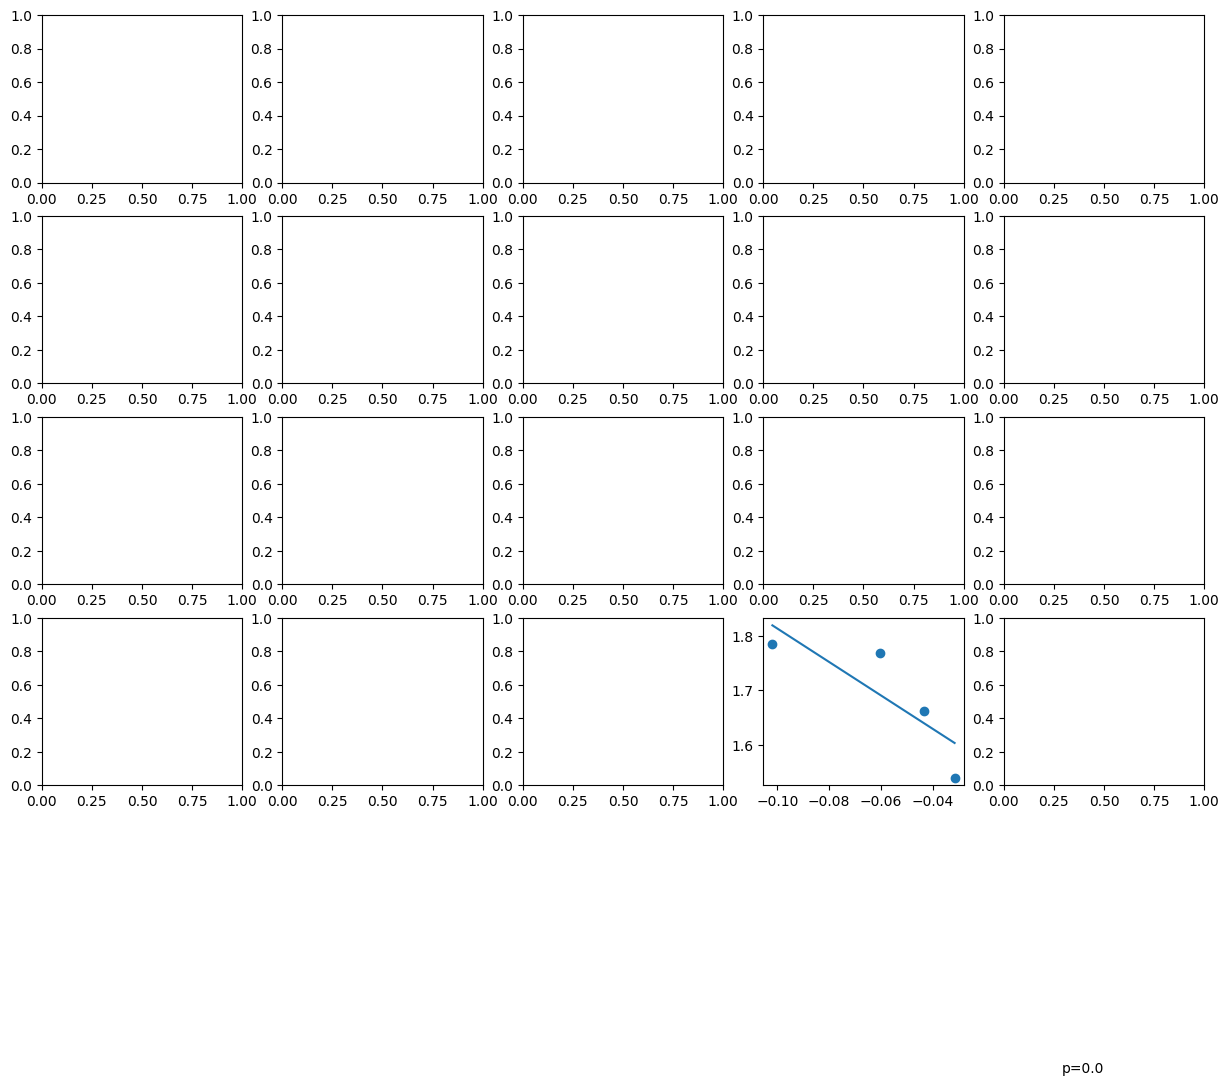

In [11]:
UEFMS_implant_resp ={'007': 5, '008': 10, '011': 12, '013': 7}
AMT_implant_resp = {'007':1.64,'008':3.75,'011':2.82,'013':2.92}
velocity = {'007':1.7843184351551014, '008': 1.767751152050771, '011': 1.6625233792878544, '013': 1.5406617516754246}
overshoot = { '007':49.824658470943746,'008': 60.92592108692344,'011': 40.329377105513785, '013': 44.89114531389569 }

Clinical = 'Vel'#, 'AMAT'] Vel, OS, UEFMS

freq_bands = ['Theta', 'Alpha', 'Low Beta', 'High Beta']
time_phases = ['Pre', 'ED', 'EC', 'PE1', 'PE2']
fig1, axes = plt.subplots(len(fmins),len(time_phases),figsize=(15,10))


for iband, (axes_row, phase) in enumerate(zip(axes,freq_bands)):
    for itime, (ax, band) in enumerate(zip(axes_row,time_phases)):
        theta_pre = []
        for sub in resp.values():
            theta_pre.append(corr_mat[sub][iband][itime])
            
        if Clinical == 'UEFMS':
            y = list(UEFMS_implant_resp.values())
        elif Clinical == 'AMAT':
            y = list(AMT_implant_resp.values())
        elif Clinical == 'Vel':
            y = list(velocity.values())
        elif Clinical == 'OS':
            y = list(overshoot.values())
        r, p = scipy.stats.spearmanr(theta_pre,y) 
        
        if p<0.05:
        
            ax.scatter(theta_pre,y)
            #obtain m (slope) and b(intercept) of linear regression line
            m, b = np.polyfit(theta_pre,y, 1)    
            #add linear regression line to scatterplot 

            ax.text(0.01,1, f'p={round(p,2)}')

            ax.plot(theta_pre, m*np.array(theta_pre)+b)


# Plot DBS ERDS 

In [19]:
dbs_chs = {'015':'mean(DBS1-DBS2, DBS2-DBS3, DBS3-DBS4, DBS4-DBS5, DBS5-DBS6, DBS6-DBS7, DBS7-DBS8)',
'014':'mean(DBS1-DBS2, DBS2-DBS3, DBS3-DBS4, DBS4-DBS5, DBS5-DBS6, DBS6-DBS7, DBS7-DBS8)',
'013':'mean(DBS1-DBS2, DBS2-DBS3, DBS3-DBS4, DBS4-DBS5, DBS5-DBS6, DBS6-DBS7, DBS7-DBS8)',
'011':'mean(DBS1-DBS2, DBS2-DBS3, DBS3-DBS4, DBS4-DBS5, DBS5-DBS6, DBS6-DBS7, DBS7-DBS8)',
'008':'mean(DBS1-2, DBS1-3, DBS1-4, DBS2-5, DBS3-6, DBS4-7, DBS5-8, DBS6-8, DBS7-8)',
'007':'mean(DBS1-2, DBS1-3, DBS1-4, DBS2-5, DBS3-6, DBS4-7, DBS5-8, DBS6-8, DBS7-8)'
}

In [13]:
dbs_chs = {'015':'DBS6-7',
'014':'DBS3-4',
'013':'DBS7-8',
'011':'DBS1-2',
'008':'DBS3-6',
'007':'DBS3-6'
}

1
2
3
No baseline correction applied
No baseline correction applied
No baseline correction applied


C:\Users\malann\AppData\Local\Temp\ipykernel_45024\2072302950.py:74: RuntimeWarning: `mask` is None, not masking the plot ...
  tfr_dbs_typ_avg_resp.copy().crop(crop_min,crop_max).plot(
C:\Users\malann\AppData\Local\Temp\ipykernel_45024\2072302950.py:82: RuntimeWarning: `mask` is None, not masking the plot ...
  tfr_dbs_odd_avg_resp.copy().crop(crop_min,crop_max).plot(
C:\Users\malann\AppData\Local\Temp\ipykernel_45024\2072302950.py:91: RuntimeWarning: `mask` is None, not masking the plot ...
  tfr_dbs_diff_avg_resp.copy().crop(crop_min,crop_max).plot(


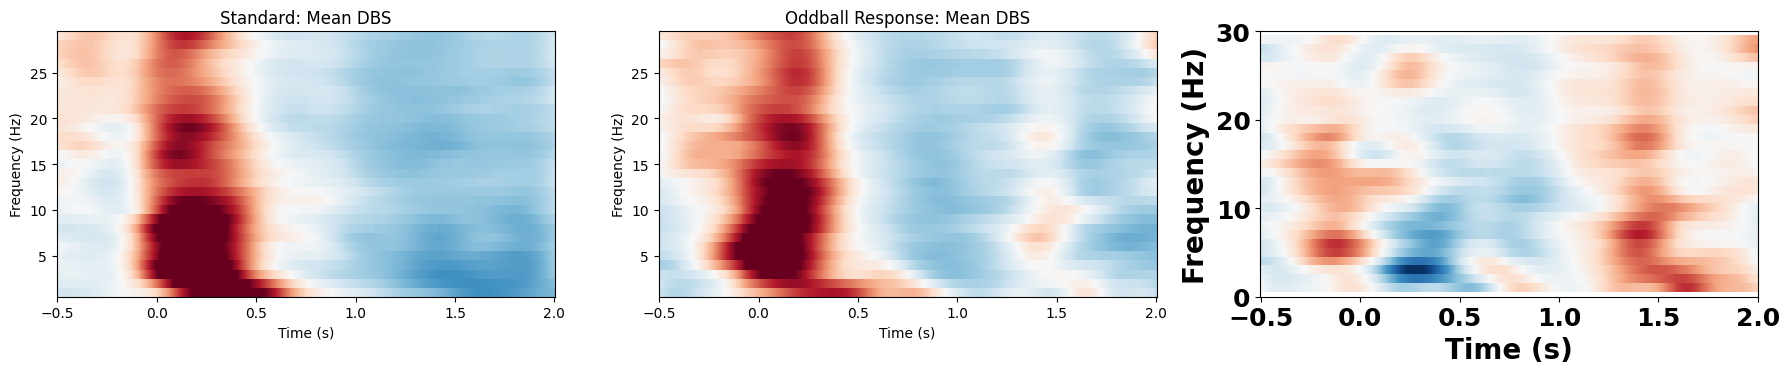

In [33]:
resp = {'007':0,'008':1,'011':2,'013':3}
non_resp = {'011':2,'013':3,'014':4,'015':5}
crop_min =-0.5
ch_info = 'DBS7-8'

task_res = ['Oddball Response'] #, 'Oddball No Response'] 
for ires, res in enumerate(task_res):
    if res == 'Oddball Response':
        resp_idx = list(resp.values())
    else:
        resp_idx = list(non_resp.values())
        
    tfr_dbs_typ_avg = []
    tfr_dbs_odd_avg = []
  
    for i_idx, i in enumerate(resp_idx):

        if res == 'Oddball Response':
            #ch_picks = tfrs_dbs_all[i][0].copy().pick(dbs_chs[list(resp.keys())[i_idx]]).ch_names
            
            ch_picks = tfrs_dbs_all[i][0].ch_names[:-1]
    
            tfr_dbs_avg1 = tfrs_dbs_all[i][0].copy().pick(ch_picks).get_data().mean(axis = 0).mean(axis=0)
            #tfr_dbs_avg1 = (tfr_dbs_avg1-tfr_dbs_avg1.min())/(tfr_dbs_avg1.max()-tfr_dbs_avg1.min()) 
            tfr_dbs_avg = tfr_dbs_avg1.reshape(1,tfr_dbs_avg1.shape[0],tfr_dbs_avg1.shape[1])
    
            tfrs_dbs_typ_avg = mne.time_frequency.AverageTFRArray(tfrs_dbs_all[i][0].copy().pick(ch_info).info, tfr_dbs_avg, tfrs_dbs_all[i][0].times, tfrs_dbs_all[i][0].freqs,comment=aff_cond_plot[0])
            tfr_dbs_typ_avg.append(tfrs_dbs_typ_avg)
        
            odd_dbs_avg1 = tfrs_dbs_all[i][2].copy().pick(ch_picks).get_data().mean(axis = 0).mean(axis=0)
            #odd_dbs_avg1 = (odd_dbs_avg1-odd_dbs_avg1.min())/(odd_dbs_avg1.max()-odd_dbs_avg1.min()) 
            odd_dbs_avg = odd_dbs_avg1.reshape(1,odd_dbs_avg1.shape[0],odd_dbs_avg1.shape[1])
    
            
            tfrs_dbs_odd_avg = mne.time_frequency.AverageTFRArray(tfrs_dbs_all[i][2].copy().pick(ch_info).info, odd_dbs_avg, tfrs_dbs_all[i][2].times, tfrs_dbs_all[i][2].freqs,comment=aff_cond_plot[2])
            tfr_dbs_odd_avg.append(tfrs_dbs_odd_avg)
       
        else:
            ch_picks = tfrs_dbs_all[i][1].copy().pick(dbs_chs[list(non_resp.keys())[i_idx]]).ch_names
            #ch_picks = tfrs_dbs_all[i][1].ch_names[:-1]
            
            tfr_dbs_avg1 = tfrs_dbs_all[i][1].copy().pick(ch_picks).get_data().mean(axis = 0).mean(axis=0)
            #tfr_dbs_avg1 = (tfr_dbs_avg1-tfr_dbs_avg1.min())/(tfr_dbs_avg1.max()-tfr_dbs_avg1.min()) 
            tfr_dbs_avg = tfr_dbs_avg1.reshape(1,tfr_dbs_avg1.shape[0],tfr_dbs_avg1.shape[1])
    
            tfrs_dbs_typ_avg = mne.time_frequency.AverageTFRArray(tfrs_dbs_all[i][1].copy().pick(ch_info).info, tfr_dbs_avg, tfrs_dbs_all[i][1].times, tfrs_dbs_all[i][1].freqs,comment=aff_cond_plot[1])
            tfr_dbs_typ_avg.append(tfrs_dbs_typ_avg)
        
            odd_dbs_avg1 = tfrs_dbs_all[i][3].copy().pick(ch_picks).get_data().mean(axis = 0).mean(axis=0)
            #odd_dbs_avg1 = (odd_dbs_avg1-odd_dbs_avg1.min())/(odd_dbs_avg1.max()-odd_dbs_avg1.min()) 
            odd_dbs_avg = odd_dbs_avg1.reshape(1,odd_dbs_avg1.shape[0],odd_dbs_avg1.shape[1])
    
            tfrs_dbs_odd_avg = mne.time_frequency.AverageTFRArray(tfrs_dbs_all[i][3].copy().pick(ch_info).info, odd_dbs_avg, tfrs_dbs_all[i][3].times, tfrs_dbs_all[i][3].freqs,comment=aff_cond_plot[3])
            tfr_dbs_odd_avg.append(tfrs_dbs_odd_avg)

    
    
    vmin, vmax = -1, 1  # set min and max ERDS values in plot
    cnorm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)  # min, center & max ERDS
    
    tfr_dbs_typ_avg_resp = tfr_dbs_typ_avg[0]
    for i in range(1, len(tfr_dbs_typ_avg)):
        print(i)
        tfr_dbs_typ_avg_resp += tfr_dbs_typ_avg[i]
    tfr_dbs_typ_avg_resp = tfr_dbs_typ_avg_resp/(i+1)
    
    
    tfr_dbs_odd_avg_resp = tfr_dbs_odd_avg[0]
    for i in range(1, len(tfr_dbs_odd_avg)):
        tfr_dbs_odd_avg_resp += tfr_dbs_odd_avg[i]
    tfr_dbs_odd_avg_resp = tfr_dbs_odd_avg_resp/(i+1)
       
    fig, axes = plt.subplots(1,3, figsize = (18,4))
    tfr_dbs_typ_avg_resp.copy().crop(crop_min,crop_max).plot(
                        ch_info,
                        colorbar=False,
                        cnorm=cnorm,
                        axes = axes[0],
                        mask_style="mask",
                        show=False
                    )
    tfr_dbs_odd_avg_resp.copy().crop(crop_min,crop_max).plot(
                        ch_info,
                        colorbar=False,
                        cnorm=cnorm,
                        axes = axes[1],
                        mask_style="mask",
                        show=False          )
    
    tfr_dbs_diff_avg_resp=tfr_dbs_odd_avg_resp-tfr_dbs_typ_avg_resp
    tfr_dbs_diff_avg_resp.copy().crop(crop_min,crop_max).plot(
                        ch_info,
                        colorbar=False,
                        cnorm=cnorm,
                        axes = axes[2],
                        mask_style="mask",
                        show=False,
                    )
    axes[0].set_title(f'Standard: Mean DBS')
    axes[1].set_title(f'{res}: Mean DBS')
    #axes[2].set_title(f'{res}: Oddball - Standard')
    import matplotlib.font_manager as fm
    
    # Define font properties for bold ticks
    font_properties = fm.FontProperties(weight='bold')
    
    # Apply to x and y ticks with larger font size
    axes[2].tick_params(axis='x', labelsize=18)  # Set x-axis tick label size
    axes[2].tick_params(axis='y', labelsize=18)  # Set y-axis tick label size
    
    # Set tick labels font weight to bold
    for tick in axes[2].get_xticklabels() + axes[2].get_yticklabels():
        tick.set_fontproperties(font_properties)
    
    # Optionally, further increase the font size of tick labels
    for tick in axes[2].get_xticklabels():
        tick.set_fontsize(18)  # Increase font size of x-tick labels
    
    for tick in axes[2].get_yticklabels():
        tick.set_fontsize(18)  # Increase font size of y-tick labels
    # Set x-axis ticks to -0.5, 0, 0.5, 1.0, etc.
    axes[2].set_xticks(np.arange(-0.5, 2.5, 0.5))  # Set the range and step for x-ticks
    
    # Set plot labels and title with larger fonts
    axes[2].set_ylim(0, 30)  # Updated y-axis limits
    axes[2].set_xlabel('Time (s)', fontsize=20, fontweight='bold')  # Increased xlabel font size and bold
    axes[2].set_ylabel('Frequency (Hz)', fontsize=20, fontweight='bold')  # Increased ylabel font size and bold

plt.tight_layout()

plt.savefig('E:/Documentation/Manuscripts/Oddball_manuscript/Fig4_sub.png', dpi=300, bbox_inches='tight')  # Save the figure containing axes[2]



# EEG ERDS correlation with Clinical scores

In [166]:
resp = {'007':0,'008':1,'011':2,'013':3}
non_resp = {'011':2,'013':3,'014':4,'015':5}
crop_min =-0.5
ch_info = 'DBS7-8'

task_res = ['Oddball Response', 'Oddball No Response'] 
for ires, res in enumerate(task_res):
    if res == 'Oddball Response':
        resp_idx = list(resp.values())
    else:
        resp_idx = list(non_resp.values())
        
    tfr_dbs_typ_avg = []
    tfr_dbs_odd_avg = []
  
    for i_idx, i in enumerate(resp_idx):

        if res == 'Oddball Response':
            #ch_picks = tfrs_dbs_all[i][0].copy().pick(dbs_chs[list(resp.keys())[i_idx]]).ch_names
            
            ch_picks = tfrs_dbs_all[i][0].ch_names[:-1]
    
            tfr_dbs_avg1 = tfrs_dbs_all[i][0].copy().pick(ch_picks).get_data().mean(axis = 0).mean(axis=0)
            #tfr_dbs_avg1 = (tfr_dbs_avg1-tfr_dbs_avg1.min())/(tfr_dbs_avg1.max()-tfr_dbs_avg1.min()) 
            tfr_dbs_avg = tfr_dbs_avg1.reshape(1,tfr_dbs_avg1.shape[0],tfr_dbs_avg1.shape[1])
    
            tfrs_dbs_typ_avg = mne.time_frequency.AverageTFR(tfrs_dbs_all[i][0].copy().pick(ch_info).info, tfr_dbs_avg, tfrs_dbs_all[i][0].times, tfrs_dbs_all[i][0].freqs,comment=aff_cond_plot[0],events=epochs.events,event_id=event_id)
            tfr_dbs_typ_avg.append(tfrs_dbs_typ_avg)
        
            odd_dbs_avg1 = tfrs_dbs_all[i][2].copy().pick(ch_picks).get_data().mean(axis = 0).mean(axis=0)
            #odd_dbs_avg1 = (odd_dbs_avg1-odd_dbs_avg1.min())/(odd_dbs_avg1.max()-odd_dbs_avg1.min()) 
            odd_dbs_avg = odd_dbs_avg1.reshape(1,odd_dbs_avg1.shape[0],odd_dbs_avg1.shape[1])
    
            
            tfrs_dbs_odd_avg = mne.time_frequency.AverageTFR(tfrs_dbs_all[i][2].copy().pick(ch_info).info, odd_dbs_avg, tfrs_dbs_all[i][2].times, tfrs_dbs_all[i][2].freqs,comment=aff_cond_plot[2],events=epochs.events,event_id=event_id)
            tfr_dbs_odd_avg.append(tfrs_dbs_odd_avg)
            
for tfr in tfr_dbs_odd_avg:
    corr_mat2=[]
    for axes1, fmin,fmax in zip(axes1_row, fmins,fmaxs):
        corr_mat1 = []
        for tmin,tmax,ax1 in zip(tmins,tmaxs,axes1):
            
            tfr_avg = tfr.copy().pick(ch_picks_ipsi).get_data().mean(axis=0)
            tfr_avg = tfr_avg.reshape(1,tfr_avg.shape[0],tfr_avg.shape[1])
            tfr_avg = mne.time_frequency.AverageTFR(tfrs_all[i][1].copy().pick(ch_picks[0]).info, tfr_avg, tfrs_all[i][1].times, tfrs_all[i][1].freqs,comment=aff_cond_plot[1],events=epochs.events,event_id=event_id)
            corr_mat1.append(tfr_avg.copy().crop(tmin=tmin, tmax=tmax,fmin=fmin, fmax=fmax).data.mean())
            
        corr_mat2.append(corr_mat1)
    corr_mat.append(corr_mat2)
    
corr_mat = np.array(corr_mat)




C:\Users\malann\AppData\Local\Temp\ipykernel_206608\1260327146.py:27: FutureWarning: Parameters "info", "data", "times" are deprecated and will be removed in version 1.8. For a quick fix, use ``AverageTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  tfrs_dbs_typ_avg = mne.time_frequency.AverageTFR(tfrs_dbs_all[i][0].copy().pick(ch_info).info, tfr_dbs_avg, tfrs_dbs_all[i][0].times, tfrs_dbs_all[i][0].freqs,comment=aff_cond_plot[0],events=epochs.events,event_id=event_id)
C:\Users\malann\AppData\Local\Temp\ipykernel_206608\1260327146.py:35: FutureWarning: Parameters "info", "data", "times" are deprecated and will be removed in version 1.8. For a quick fix, use ``AverageTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  tfrs_dbs_odd_avg = mne.time_frequency.AverageTFR(tfrs_dbs_all[i][2].copy().pick(ch_info).info, odd_dbs_avg, tfrs_dbs_all[i][2].times, tfrs_dbs_all[i][2].freqs,comment=aff_cond_plot[2],events=epochs.events

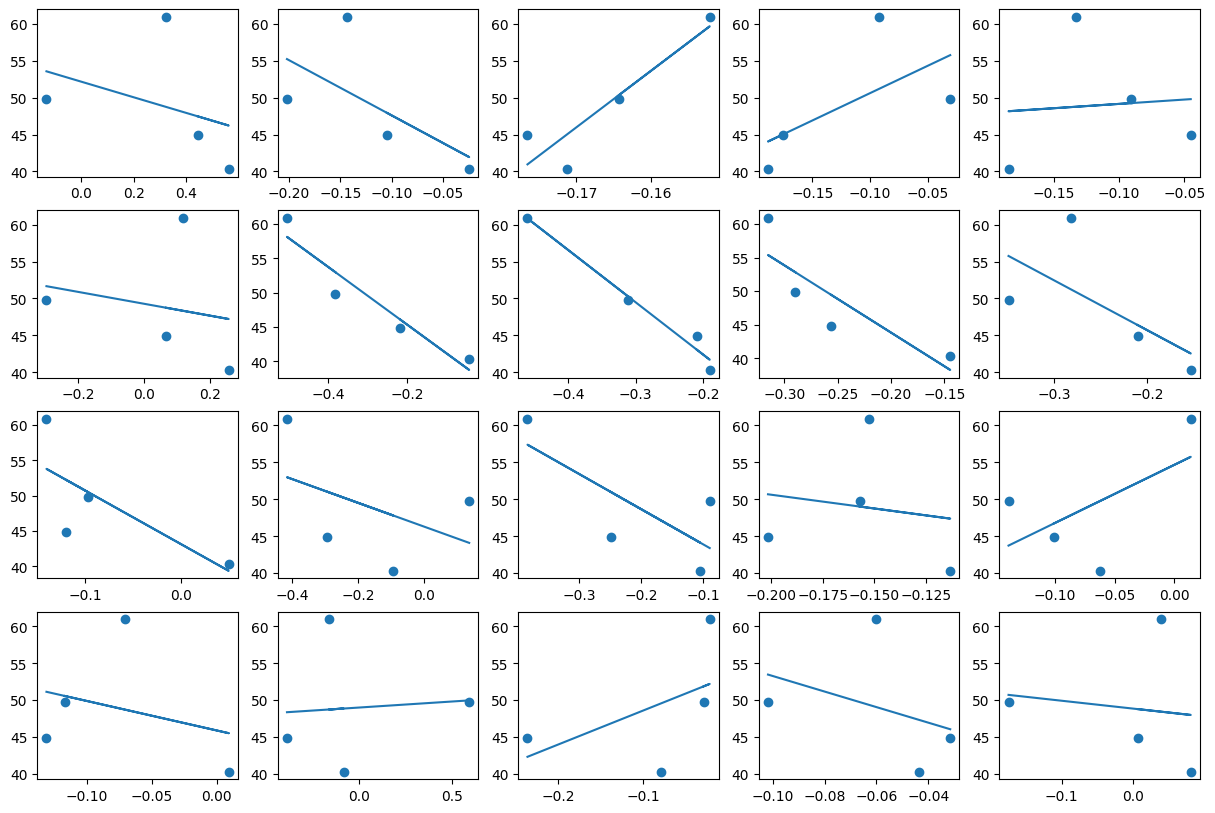

In [170]:
UEFMS_implant_resp ={'007': 5, '008': 10, '011': 12, '013': 7}
AMT_implant_resp = {'007':1.64,'008':3.75,'011':2.82,'013':2.92}
velocity = {'007':1.7843184351551014, '008': 1.767751152050771, '011': 1.6625233792878544, '013': 1.5406617516754246}
overshoot = { '007':49.824658470943746,'008': 60.92592108692344,'011': 40.329377105513785, '013': 44.89114531389569 }

Clinical = 'OS'#, 'AMAT'] Vel, OS, UEFMS

freq_bands = ['Theta', 'Alpha', 'Low Beta', 'High Beta']
time_phases = ['Pre', 'ED', 'EC', 'PE1', 'PE2']
fig1, axes = plt.subplots(len(fmins),len(time_phases),figsize=(15,10))


for iband, (axes_row, phase) in enumerate(zip(axes,freq_bands)):
    for itime, (ax, band) in enumerate(zip(axes_row,time_phases)):
        theta_pre = []
        for sub in resp.values():
            theta_pre.append(corr_mat[sub][iband][itime])
            
        if Clinical == 'UEFMS':
            y = list(UEFMS_implant_resp.values())
        elif Clinical == 'AMAT':
            y = list(AMT_implant_resp.values())
        elif Clinical == 'Vel':
            y = list(velocity.values())
        elif Clinical == 'OS':
            y = list(overshoot.values())
            
        ax.scatter(theta_pre,y)
        #obtain m (slope) and b(intercept) of linear regression line
        m, b = np.polyfit(theta_pre,y, 1)    
        #add linear regression line to scatterplot 
        ax.plot(theta_pre, m*np.array(theta_pre)+b)


# Excel Sheet of ERDS

In [172]:
f_max_time

[0.58, 0.53, 0.655, 0.685, 0.845, 0.705]

In [ ]:
subj_list = ['007','008','011','013','014','015']

for i, (sub, tfr_all) in enumerate(zip(subj_list, tfrs_all)):
    
    if subj_list == ['013'] or subj_list == ['014'] or subj_list == ['015']:
        ch_picks =['F8','FC2','FC6','C4','CP2','CP6','Cz']
    else:
        ch_picks =['Fz','F4','FC6','FC2','C4','CP6','CP2','Cz']

        
    ch_picks = ['FC2','FC1','Cz','Fz','CP2','CP1','Pz','FC6','C4']       

        
    df1 = tfrs_all[i][0].copy().pick(ch_picks).to_data_frame(time_format=None, long_format=True)
    df2 = tfrs_all[i][1].copy().pick(ch_picks).to_data_frame(time_format=None, long_format=True)
    df3 = tfrs_all[i][2].copy().pick(ch_picks).to_data_frame(time_format=None, long_format=True)
    df4 = tfrs_all[i][3].copy().pick(ch_picks).to_data_frame(time_format=None, long_format=True)

    df5 = tfrs_dbs_all[i][0].to_data_frame(time_format=None, long_format=True)
    df6 = tfrs_dbs_all[i][1].to_data_frame(time_format=None, long_format=True)
    df7 = tfrs_dbs_all[i][2].to_data_frame(time_format=None, long_format=True)
    df8 = tfrs_dbs_all[i][3].to_data_frame(time_format=None, long_format=True)

    frames = [df1, df2, df3, df4, df5, df6, df7, df8]
    df = pd.concat(frames)
    # Map to frequency bands:
    freq_bounds = {"_": 0, "[0 3]": 4, "[4 7]": 8, "[8 12]": 13, "[13 20]": 20, "[21 30]": 30}
    time_bounds = {"_": -0.5, "[-0.5 0]": 0, f'[0 {f_max_time[i]} ]': f_max_time[i], f'[{f_max_time[i]} 1.1]': 1.1, "[1.1, 1.5]": 1.5, "[1.5 2]": 2}


    df["band"] = pd.cut(
        df["freq"], list(freq_bounds.values()), labels=list(freq_bounds)[1:]
    )

    df["Time_dur"] = pd.cut(
        df["time"], list(time_bounds.values()), labels=list(time_bounds)[1:]
    )

    # Filter to retain only relevant frequency bands:
    freq_bands_of_interest = [ "[4 7]","[8 12]", "[13 20]", "[21 30]"]
    time_of_interest = ["[-0.5 0]", f'[0 {f_max_time[i]} ]', f'[{f_max_time[i]} 1.1]', "[1.1, 1.5]", "[1.5 2]"]

    df = df[df.band.isin(freq_bands_of_interest)]
    df = df[df.Time_dur.isin(time_of_interest)]

    df["band"] = df["band"].cat.remove_unused_categories()
    df["Time_dur"] = df["Time_dur"].cat.remove_unused_categories()


    df_mean = (
        df.groupby(["condition", "Time_dur", "band", "channel"], observed=False)[["value"]]
        .mean()
        .reset_index()
    )
    df_mean.insert(0,'Stage', len(df_mean)*[st])
    df_mean.insert(1,'Subject', len(df_mean)*[sub])

    header = ["Stage", "Subject", "Condition", "Time", "Freq",'Channel', "ERDS"]
    if i == 0:
        df_mean.to_csv(base_dir+'Oddball_ERDS_E_NE1.csv', mode='a', index=False, header=header)
    else:
        df_mean.to_csv(base_dir+'Oddball_ERDS_E_NE1.csv', mode='a', index=False, header=False)


# Coherence

No baseline correction applied


C:\Users\malann\AppData\Local\Temp\ipykernel_206608\1271049789.py:38: FutureWarning: Parameters "info", "data", "times", "nave" are deprecated and will be removed in version 1.8. For a quick fix, use ``AverageTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  tfr_odd = mne.time_frequency.AverageTFR(epochs_aff_odd.copy().pick('Cz').info, CCC_odd_mean, epochs_aff_odd.times, np.arange(1,41), len(epochs_aff_odd))
C:\Users\malann\AppData\Local\Temp\ipykernel_206608\1271049789.py:39: FutureWarning: Parameters "info", "data", "times", "nave" are deprecated and will be removed in version 1.8. For a quick fix, use ``AverageTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  tfr_typ = mne.time_frequency.AverageTFR(epochs_aff_odd.copy().pick('Cz').info, CCC_typ_mean, epochs_aff_odd.times, np.arange(1,41), len(epochs_aff_odd))
C:\Users\malann\AppData\Local\Temp\ipykernel_206608\1271049789.py:40: FutureWarning: Parameters "info", "d

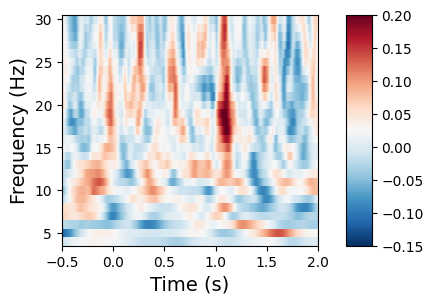

In [173]:
CCC_odd1base_dir = "E:/Oddball Data/"
subj_list = ['007','008','011','013']

stg = ['implant']#, 'implant']explant

CCC_odd= []
CCC_typ= []
CCC = []

for st in stg:
    for sub in subj_list:        
        file = f"{base_dir}CCC_Oddball_E_{sub}_{st}.npy"
        CCC_odd.append(np.load(file))
        file = f"{base_dir}CCC_Standard_E_{sub}_{st}.npy"
        CCC_typ.append(np.load(file))
        file = f"{base_dir}CCC_E_{sub}_{st}.npy"
        CCC.append(np.load(file))

CCC_odd1 = np.array(CCC_odd)
CCC_odd = np.array(CCC_odd)
CCC_odd_mean = CCC_odd.mean(axis=0)
CCC_odd_mean= CCC_odd_mean.reshape(1,CCC_odd_mean.shape[0],CCC_odd_mean.shape[1])

CCC_typ1 = np.array(CCC_typ)
CCC_typ = np.array(CCC_typ)
CCC_typ_mean = CCC_typ.mean(axis=0)
CCC_typ_mean= CCC_typ_mean.reshape(1,CCC_typ_mean.shape[0],CCC_typ_mean.shape[1])

CCC = np.array(CCC)
CCC_mean = CCC.mean(axis=0)
CCC_mean= CCC_mean.reshape(1,CCC_mean.shape[0],CCC_mean.shape[1])

tmin = -0.5
tmax = 2
vmax=0.2
vmin=-0.15

tfr_odd = mne.time_frequency.AverageTFR(epochs_aff_odd.copy().pick('Cz').info, CCC_odd_mean, epochs_aff_odd.times, np.arange(1,41), len(epochs_aff_odd))
tfr_typ = mne.time_frequency.AverageTFR(epochs_aff_odd.copy().pick('Cz').info, CCC_typ_mean, epochs_aff_odd.times, np.arange(1,41), len(epochs_aff_odd))
tfr = mne.time_frequency.AverageTFR(epochs_aff_odd.copy().pick('Cz').info, CCC_mean, epochs_aff_odd.times, np.arange(1,41), len(epochs_aff_odd))

#tfr_odd.plot('C4', tmin=tmin,tmax=tmax, vmax=vmax,vmin=vmin)
#tfr_typ.plot('C4', tmin=tmin,tmax=tmax, vmax=vmax,vmin=vmin)

width_ratios = [10, 1]
fig, ax = plt.subplots(1, 2, figsize=(4, 3), gridspec_kw={"width_ratios": width_ratios})

ax[0].set_ylabel('Frequency (Hz)', fontsize=14)
ax[0].set_xlabel('Time (s)', fontsize=14)

tfr.plot('Cz', tmin=tmin,tmax=tmax, fmin=4,fmax=30, axes=ax[0],vmax=vmax,vmin=vmin,colorbar=False,show=False)
fig.colorbar(ax[0].images[-1], cax=ax[1])

In [186]:
CCC_odd1base_dir = "E:/Oddball Data/"
subj_list = ['007','008','011','013']

stg = ['implant']#, 'implant']explant

CCC_odd= []
CCC_typ= []
CCC = []
tfr_CCC_odd=[]
for st in stg:
    for sub in subj_list:        
        file = f"{base_dir}CCC_Oddball_E_{sub}_{st}.npy"
        CCC_odd = np.load(file)
        CCC_odd = CCC_odd.reshape(1,CCC_odd.shape[0],CCC_odd.shape[1])
        
        tfr_CCC_odd.append(mne.time_frequency.AverageTFR(epochs_aff_odd.copy().pick('Cz').info, CCC_odd, epochs_aff_odd.times, np.arange(1,41), len(epochs_aff_odd)))

corr_mat=[]

for tfr in tfr_CCC_odd:
    corr_mat2=[]
    for axes1, fmin,fmax in zip(axes1_row, fmins,fmaxs):
        corr_mat1 = []
        for tmin,tmax,ax1 in zip(tmins,tmaxs,axes1):
            
            tfr_avg = tfr.copy().data.mean(axis=0)
            tfr_avg = tfr_avg.reshape(1,tfr_avg.shape[0],tfr_avg.shape[1])
            tfr_avg = mne.time_frequency.AverageTFR(epochs_aff_odd.copy().pick('Cz').info, tfr_avg, epochs_aff_odd.times, np.arange(1,41), len(epochs_aff_odd))
            corr_mat1.append(tfr_avg.copy().crop(tmin=tmin, tmax=tmax,fmin=fmin, fmax=fmax).data.mean())
            
        corr_mat2.append(corr_mat1)
    corr_mat.append(corr_mat2)
    
corr_mat = np.array(corr_mat)

C:\Users\malann\AppData\Local\Temp\ipykernel_206608\3689101277.py:16: FutureWarning: Parameters "info", "data", "times", "nave" are deprecated and will be removed in version 1.8. For a quick fix, use ``AverageTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  tfr_CCC_odd.append(mne.time_frequency.AverageTFR(epochs_aff_odd.copy().pick('Cz').info, CCC_odd, epochs_aff_odd.times, np.arange(1,41), len(epochs_aff_odd)))
C:\Users\malann\AppData\Local\Temp\ipykernel_206608\3689101277.py:16: FutureWarning: Parameters "info", "data", "times", "nave" are deprecated and will be removed in version 1.8. For a quick fix, use ``AverageTFRArray`` with the same parameters. For a long-term fix, see the docstring notes.
  tfr_CCC_odd.append(mne.time_frequency.AverageTFR(epochs_aff_odd.copy().pick('Cz').info, CCC_odd, epochs_aff_odd.times, np.arange(1,41), len(epochs_aff_odd)))
C:\Users\malann\AppData\Local\Temp\ipykernel_206608\3689101277.py:16: FutureWarning: Parameters 

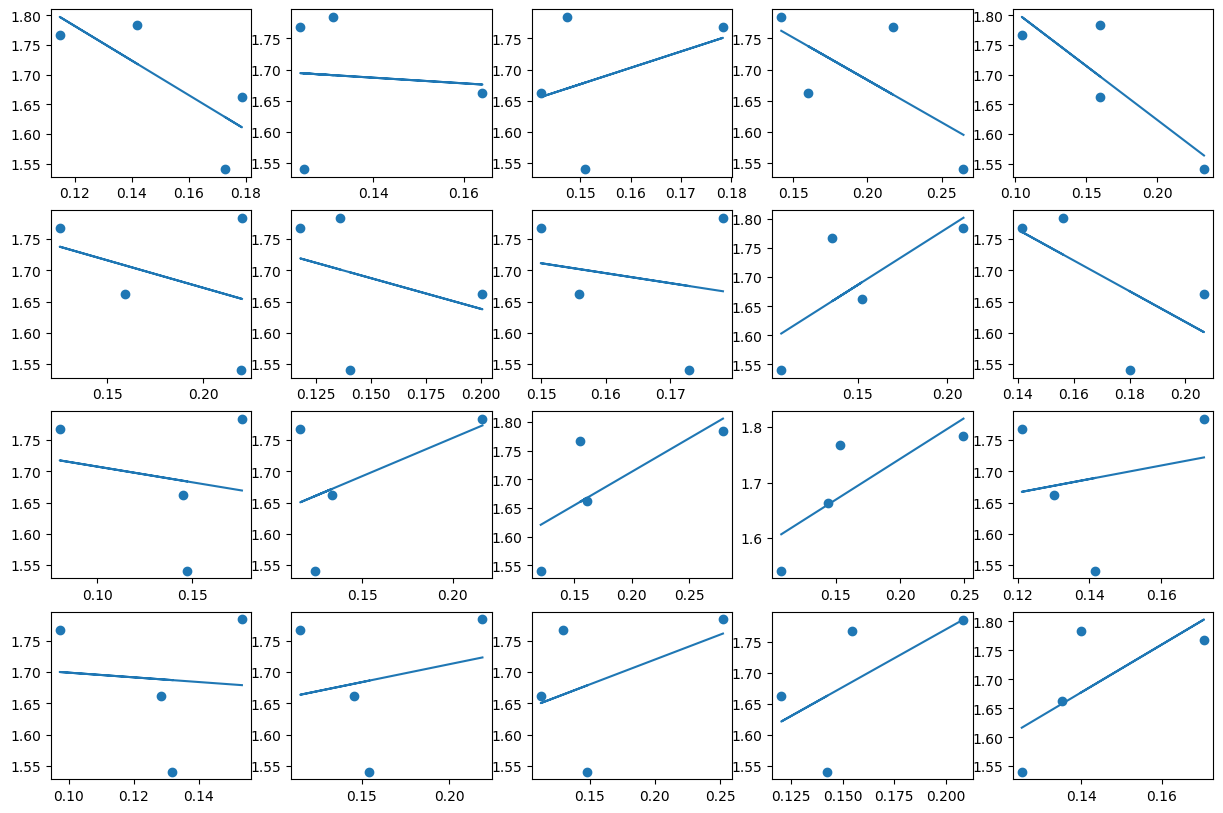

In [202]:
UEFMS_implant_resp ={'007': 5, '008': 10, '011': 12, '013': 7}
AMT_implant_resp = {'007':1.64,'008':3.75,'011':2.82,'013':2.92}
velocity = {'007':1.7843184351551014, '008': 1.767751152050771, '011': 1.6625233792878544, '013': 1.5406617516754246}
overshoot = { '007':49.824658470943746,'008': 60.92592108692344,'011': 40.329377105513785, '013': 44.89114531389569 }

Clinical = 'Vel'#, 'AMAT'] Vel, OS, UEFMS

freq_bands = ['Theta', 'Alpha', 'Low Beta', 'High Beta']
time_phases = ['Pre', 'ED', 'EC', 'PE1', 'PE2']
fig1, axes = plt.subplots(len(fmins),len(time_phases),figsize=(15,10))


for iband, (axes_row, phase) in enumerate(zip(axes,freq_bands)):
    for itime, (ax, band) in enumerate(zip(axes_row,time_phases)):
        theta_pre = []
        for sub in resp.values():
            theta_pre.append(corr_mat[sub][iband][itime])
            
        if Clinical == 'UEFMS':
            y = list(UEFMS_implant_resp.values())
        elif Clinical == 'AMAT':
            y = list(AMT_implant_resp.values())
        elif Clinical == 'Vel':
            y = list(velocity.values())
        elif Clinical == 'OS':
            y = list(overshoot.values())
            
        ax.scatter(theta_pre,y)
        #obtain m (slope) and b(intercept) of linear regression line
        m, b = np.polyfit(theta_pre,y, 1)    
        #add linear regression line to scatterplot 
        ax.plot(theta_pre, m*np.array(theta_pre)+b)
